In [14]:
import numpy as np
from numpy import linalg as LA
from findiff import *
import matplotlib.pyplot as plt

In [15]:
N = 100
h = 1.0/(N-1)
shape = (N, N)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
X, Y = np.meshgrid(x, y, indexing='ij')

In [16]:
#exact = X**2 + Y**2 + X**Y
#MA = 3 + np.zeros(shape)

##exact = 0.5*X**4 + X**2 + Y**2
##MA = (6*X**2 + 2)*2

#exact = 0.5*(X-0.5)**4 + X**2 + Y**2
#MA = 12*(X-0.5)**2 + 4

##exact = 0.5*(X-0.5)**4 + Y**2
##MA = 12*(X-0.5)**2

#exact = np.exp(0.5*(X**2 + Y**2)) + 0.3*(X**2 + Y**2)

## This is very strange. If we use numerically computed MA instead of the 
## analytic expressions, ee get convergence within machine epsilon even for a very coarse grid
##exact = np.exp(0.5*(X**2 + Y**2))      
##MA = (1+X**2+Y**2)*np.exp(X**2+Y**2)

## With numerically computed MA this one behaves more like you'd expect. 
## With the analytic expressions, pretty much same as the example above

##exact = np.exp(0.25*((X-Y)**2 + (X+Y)**2))
##MA = (1+X**2+Y**2)*np.exp(X**2+Y**2)

##exact = np.exp(0.5*(X**4 + Y**2))      ## Degenerate for x=0
##MA = 2*X**2*(2*X**4+3*Y**2+3)*np.exp(X**4+Y**2)

##exact = -np.sqrt(2 - X**2 - Y**2)
##MA = np.minimum(2.0/(2-X**2-Y**2)**2, 1e6)

#exact = 0.5*np.maximum(0, np.sqrt((X-0.5)**2 + (Y-0.5)**2) - 0.2)**2
#MA =np.maximum(0,1-0.2/(np.sqrt((X-0.5)**2 + (Y-0.5)**2) - 0.2))

##exact = 0.2*(X**2 + Y**2) + np.maximum(X**4+Y**2,Y**4+X**2)

#exact = np.maximum(X,Y)   ## Works much better than expected
#exact = np.maximum(X**2, Y**2) ## Works much worse than I expected

#exact = 0.2*(X**2 + Y**2) + np.maximum(X, Y)   ## Terrible. The computed Hessian has non-positive determinant almost everywhere
#MA = 0.8 + np.zeros(shape)
##
## Evil example. There is no convex function whose Laplace is 2sqrt(MA)

##exact = 1.0 + np.zeros(shape)
##MA = (X**2 + Y**2)**(3/2) * (np.sqrt(X**2 + Y**2) - 2)**2

#a = 0.9
#R2 = X**2 + Y**2
#R = np.sqrt(R2)
#MA=(16.2 - 16*R2)**2 / 4
#b=2.031
#c=1.52
#d=0.88
#exact=0.5*b*((R**2 -c)*np.sqrt((R**2-c)**2 +d**2)+d**2 *np.log((R**2 -c)+np.sqrt((R**2 -c)**2 +d**2)))
#exact = np.sqrt(450*a**4*R2  - 360*a**2*R2**2 + 96*R2**3) / (768 * R * np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2)) * (75 * a**4 * np.log(np.sqrt(96)*R2 - 15*np.sqrt(96)*a**2/8 + np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2)) * np.sqrt(96) + (64*R2 - 120)*np.sqrt(450*a**4 - 360*R2*a**2 + 96*R2**2))

##print(exact)
##print(d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact))

In [17]:
##print(exact)
##print(d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact))

In [18]:
d_dx = FinDiff(0, h, 1)
d_dy = FinDiff(1, h, 1)

a = 2

d2_dx2 = FinDiff(0, h, 2, acc=a)
d2_dy2 = FinDiff(1, h, 2, acc=a)
d2_dxdy = FinDiff((0, h, 1), (1, h, 1), acc=a)
d2_dydx = FinDiff((1, h, 1), (0, h, 1), acc=a)

d2_dx2_4 = FinDiff(0, h, 2, acc=4)
d2_dy2_4 = FinDiff(1, h, 2, acc=4)
d2_dxdy_4 = FinDiff((0, h, 1), (1, h, 1), acc=4)
d2_dydx_4 = FinDiff((1, h, 1), (0, h, 1), acc=4)

In [28]:
## If the exact MA is not available, we can try to compute a numerical approximation
## but, this seems to give "too good" solutions, so it's probably better to avoid this

f = 2.0 * np.sqrt(np.maximum(0, d2_dx2(exact)*d2_dy2(exact) - d2_dxdy(exact)*d2_dydx(exact)))

## Use the exact MA if available
#f = 2.0*np.sqrt(MA)

In [29]:
bc = BoundaryConditions(shape)
bc[1,:] = exact
bc[-1,:] = exact
bc[:, 1] = exact
bc[:, -1] = exact

In [30]:
singularity = np.zeros(shape)

In [31]:
def Bellman(u00, u01, u11):

    B = np.array([[u00, u01], [u01, u11]])
    
    eigenvalues, eigenvectors = LA.eigh(B)
    T = eigenvectors
    
    D = LA.det(B)

    ## Can we do something better for D <= 0? In particular for D=0?
    ## For now, default to B=I and keep track of the number of grind points 
    ## where convexity of the computed solution fails


    if (D <= 0):
        ##print("Not positive definite!")
        return np.identity(2), D
        
    Ap = np.sqrt(D) * np.diag(1/eigenvalues)
    A = T @ Ap @ T.transpose()

    ## print("A = ", A)

    return A, 0

In [32]:
def search_points_c1(k,j):
    for m in range(0,j+1):
        #print("s",singularity[k][m])
        if singularity[k][j-m]==0:
            return j-m
    return j
def search_points_c2(k,j):
    for m in range(j+1,N):
        #print("s",singularity[k][m])
        if singularity[k][m]==0:
            return m
    return j
def search_points_r1(k,j):
    for m in range(0,k+1):
        #print("s",singularity[k][m])
        if singularity[k-m][j]==0:
            return k-m
    return k
def search_points_r2(k,j):
    for m in range(k+1,N):
        #print("s",singularity[k][m])
        if singularity[m][j]==0:
            return m
    return k

In [33]:
def interpolation(k,j,r1,r2,c1,c2):
    d_r=r2-r1
    d_c=c2-c1
    A=(1/(d_r+d_c))*(k-r1)*np.array([[B00[r1][j],B01[r1][j]],[B01[r1][j],B11[r1][j]]])
    + (1/(d_r+d_c))*(r2-k)*np.array([[B00[r2][j],B01[r2][j]],[B01[r2][j],B11[r2][j]]])
    +(1/(d_r+d_c))*(j-c1)*np.array([[B00[k][c1],B01[k][c1]],[B01[k][c1],B11[k][c1]]])
    +(1/(d_r+d_c))*(c2-j)*np.array([[B00[k][c2],B01[k][c2]],[B01[k][c2],B11[k][c2]]])
    det_A=LA.det(A)
    C=A/np.sqrt(det_A)
    return C
    

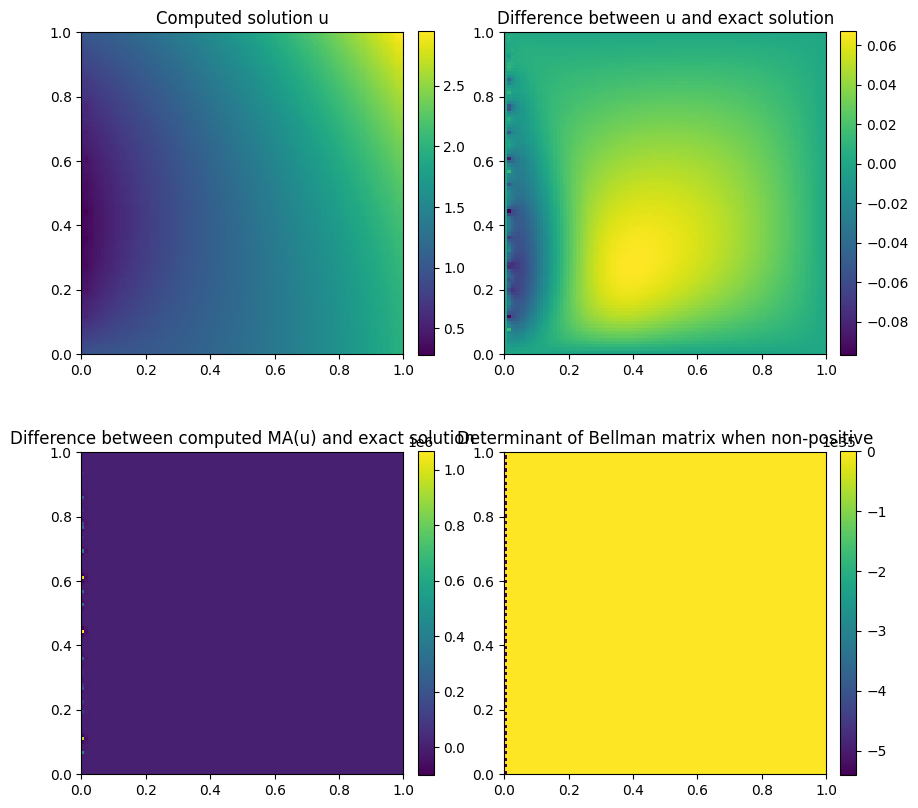

N =  100
Computed solution : Maximal error =  9.70e-02 Average l^2 error =  3.36e-04
Computed MA       : Maximal error =  1.07e+06 Average l^2 error =  2.07e+02  Two outermost layers excluded
Degeneracy count =  3669 (38.2%)


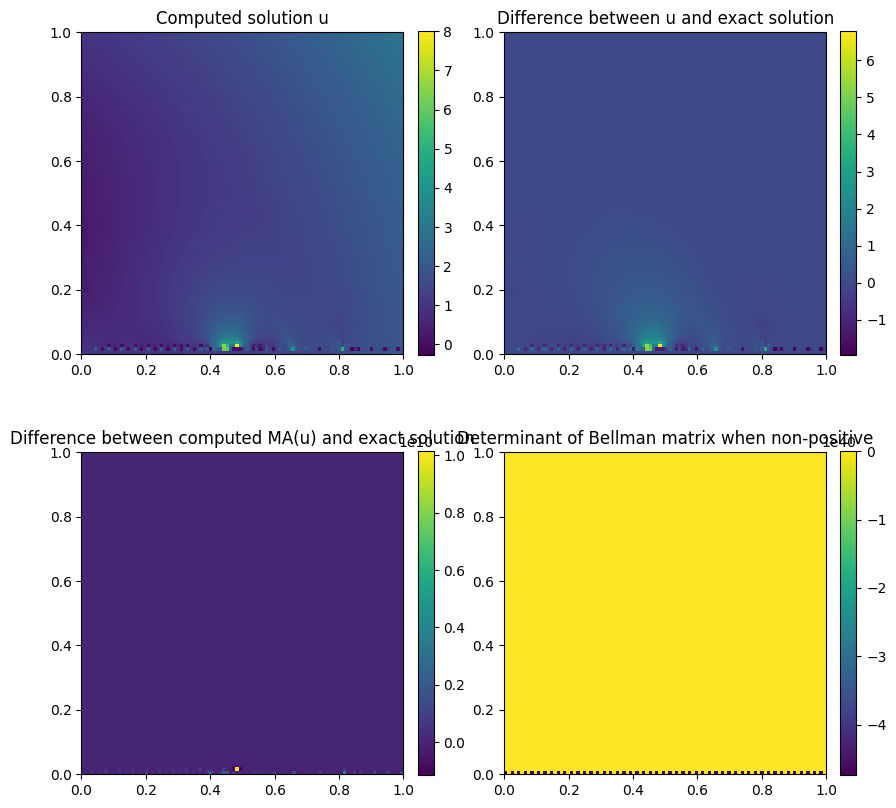

N =  100
Computed solution : Maximal error =  6.79e+00 Average l^2 error =  2.58e-03
Computed MA       : Maximal error =  1.01e+10 Average l^2 error =  1.28e+06  Two outermost layers excluded
Degeneracy count =  4740 (49.4%)


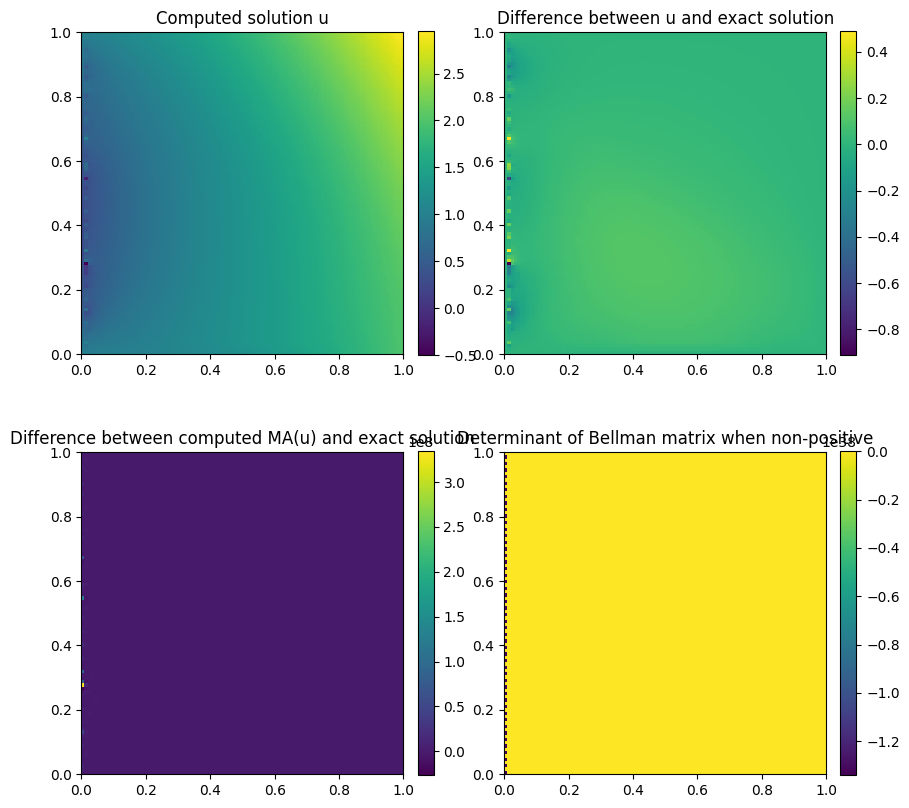

N =  100
Computed solution : Maximal error =  9.12e-01 Average l^2 error =  5.71e-04
Computed MA       : Maximal error =  3.34e+08 Average l^2 error =  4.07e+04  Two outermost layers excluded
Degeneracy count =  4469 (46.5%)


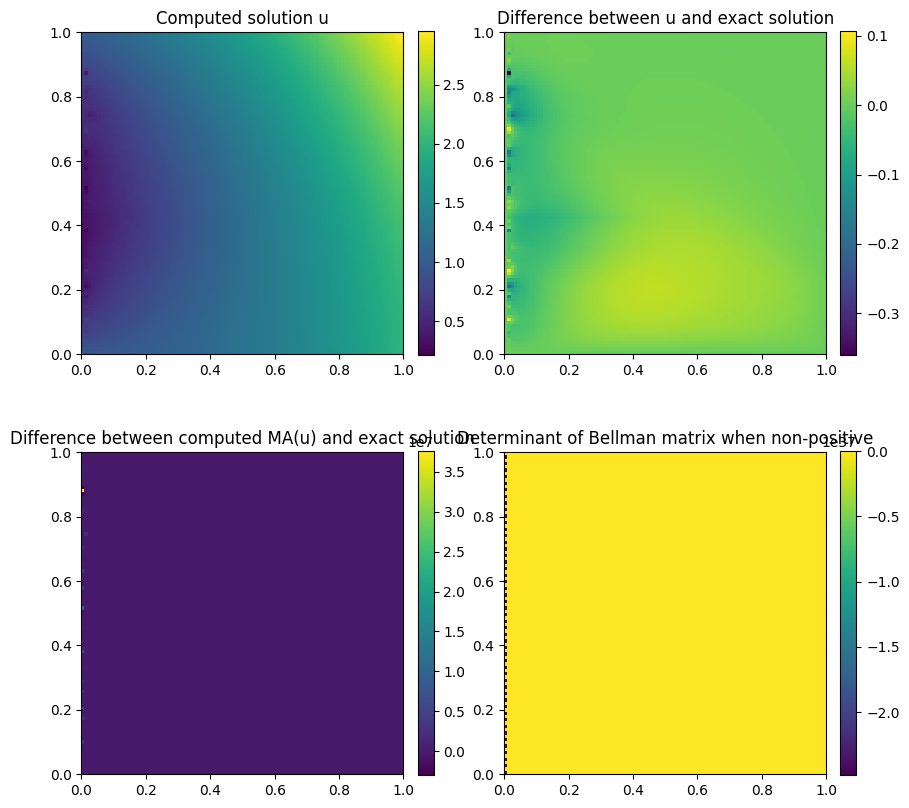

N =  100
Computed solution : Maximal error =  3.61e-01 Average l^2 error =  2.81e-04
Computed MA       : Maximal error =  3.75e+07 Average l^2 error =  4.23e+03  Two outermost layers excluded
Degeneracy count =  4157 (43.3%)


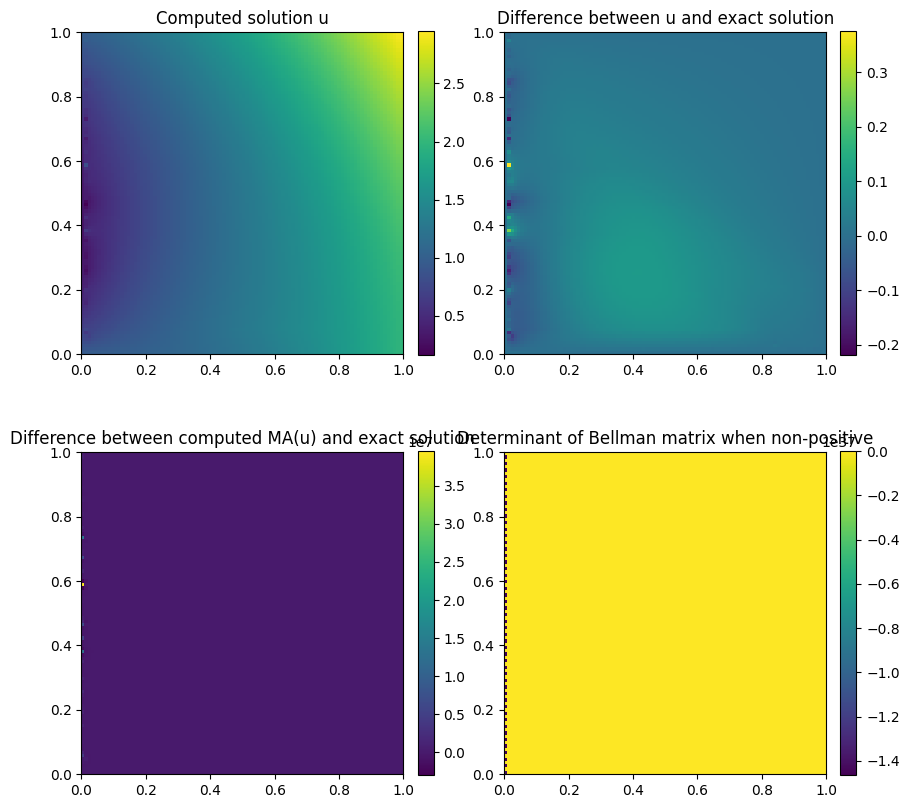

N =  100
Computed solution : Maximal error =  3.75e-01 Average l^2 error =  4.41e-04
Computed MA       : Maximal error =  3.95e+07 Average l^2 error =  4.76e+03  Two outermost layers excluded
Degeneracy count =  3893 (40.5%)


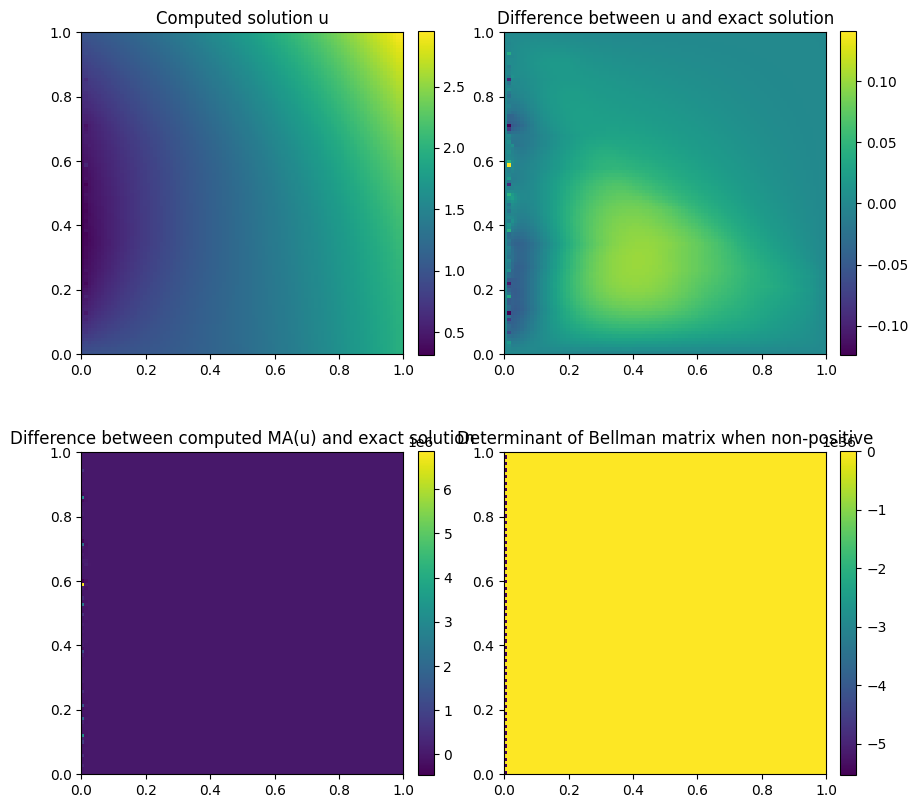

N =  100
Computed solution : Maximal error =  1.41e-01 Average l^2 error =  4.06e-04
Computed MA       : Maximal error =  6.86e+06 Average l^2 error =  9.79e+02  Two outermost layers excluded
Degeneracy count =  3672 (38.2%)


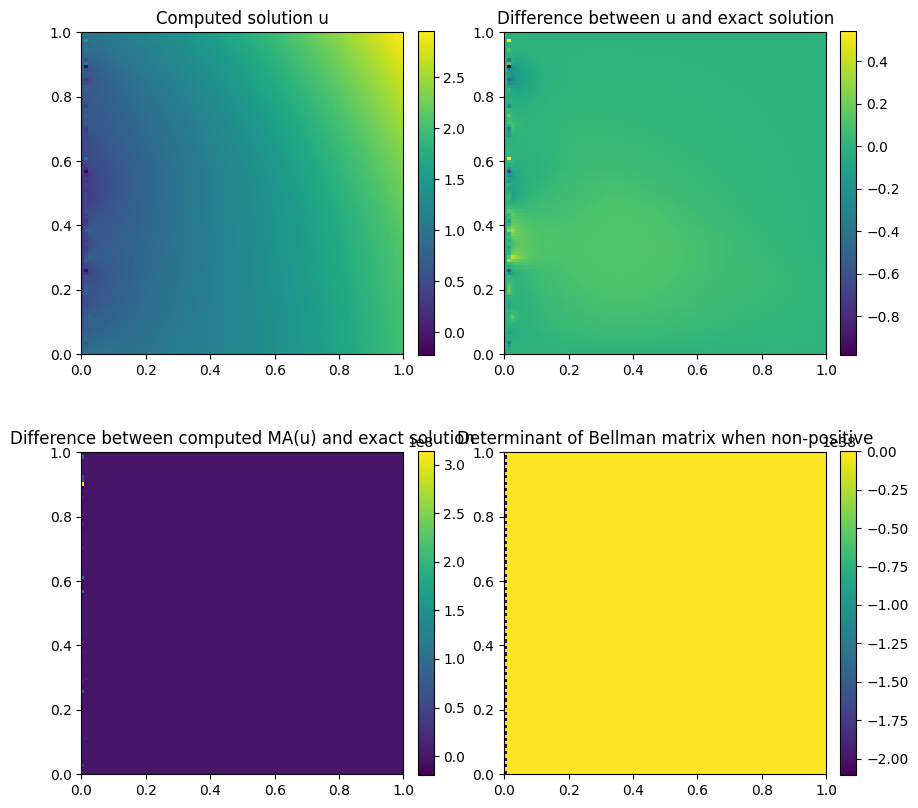

N =  100
Computed solution : Maximal error =  9.84e-01 Average l^2 error =  6.02e-04
Computed MA       : Maximal error =  3.14e+08 Average l^2 error =  4.08e+04  Two outermost layers excluded
Degeneracy count =  3514 (36.6%)


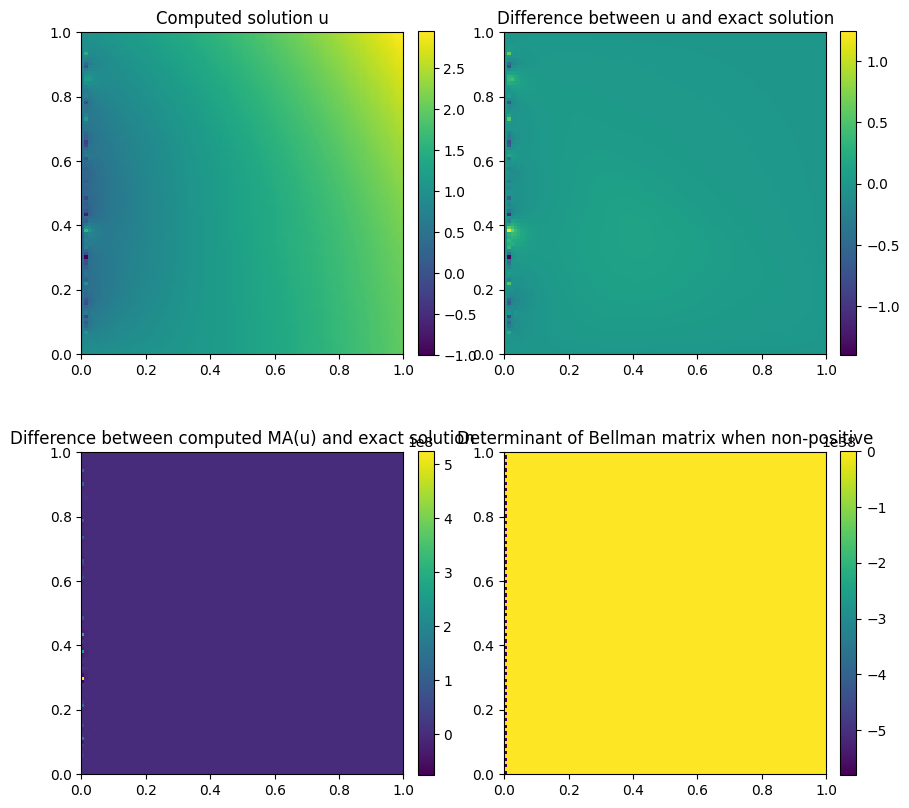

N =  100
Computed solution : Maximal error =  1.40e+00 Average l^2 error =  6.62e-04
Computed MA       : Maximal error =  5.24e+08 Average l^2 error =  8.12e+04  Two outermost layers excluded
Degeneracy count =  3419 (35.6%)


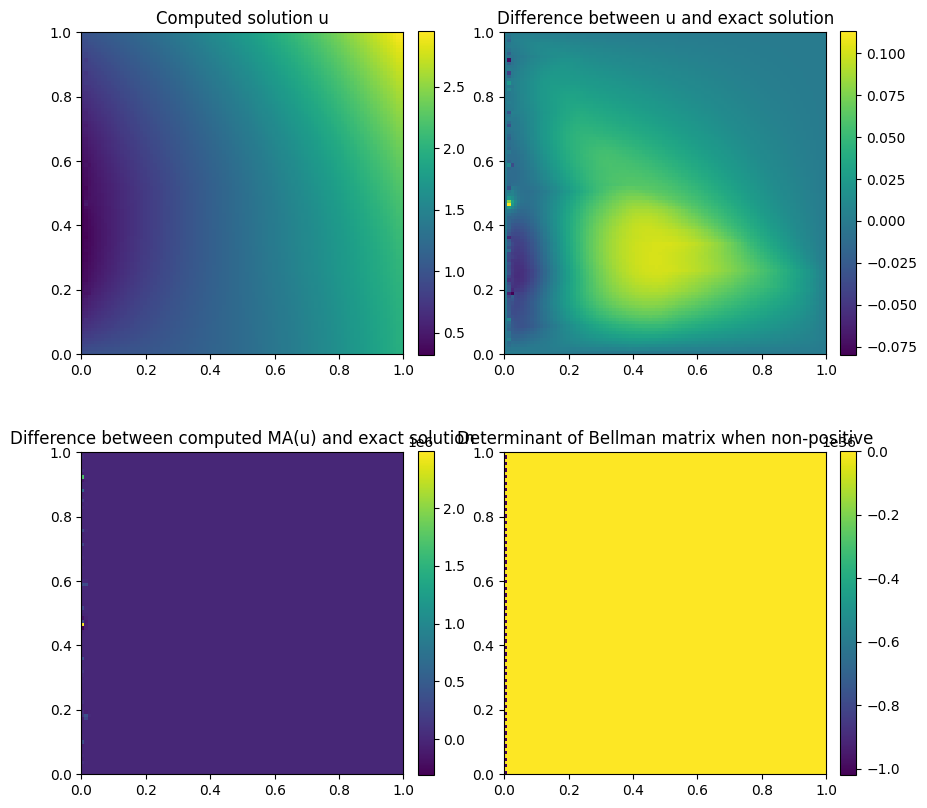

N =  100
Computed solution : Maximal error =  1.13e-01 Average l^2 error =  4.21e-04
Computed MA       : Maximal error =  2.49e+06 Average l^2 error =  3.42e+02  Two outermost layers excluded
Degeneracy count =  3443 (35.8%)


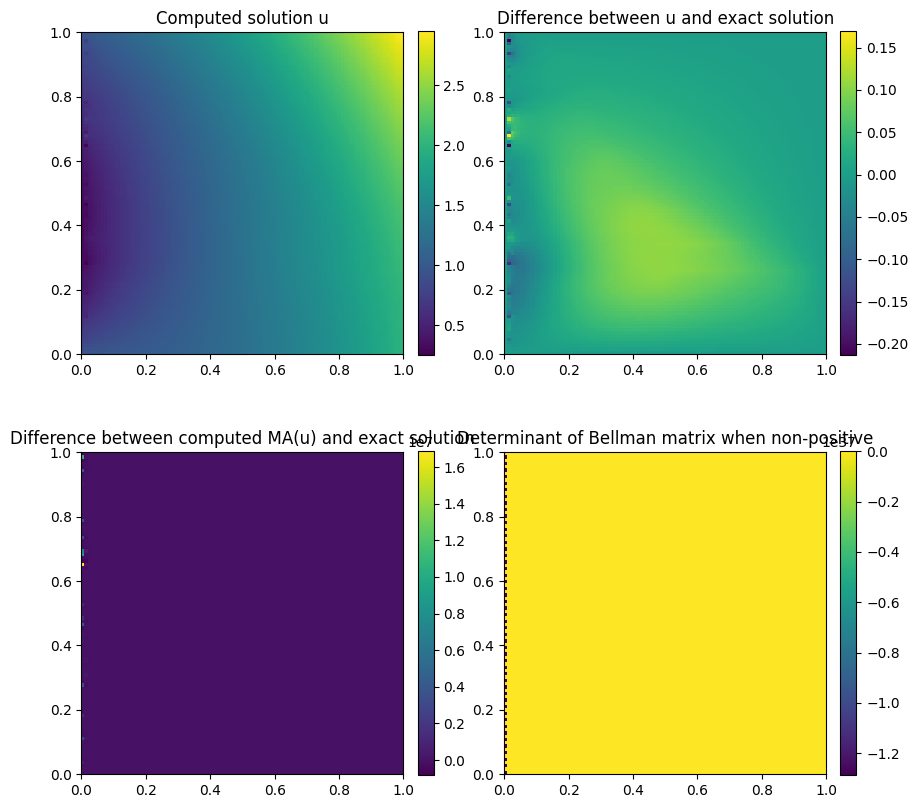

N =  100
Computed solution : Maximal error =  2.13e-01 Average l^2 error =  4.70e-04
Computed MA       : Maximal error =  1.69e+07 Average l^2 error =  2.61e+03  Two outermost layers excluded
Degeneracy count =  3331 (34.7%)


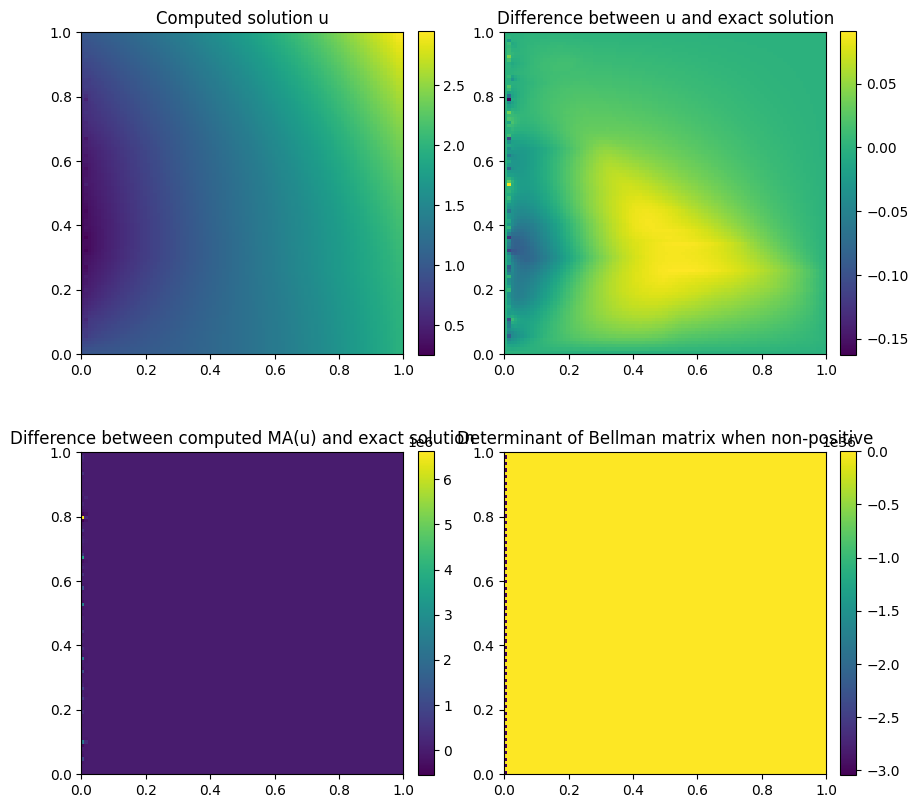

N =  100
Computed solution : Maximal error =  1.63e-01 Average l^2 error =  3.90e-04
Computed MA       : Maximal error =  6.62e+06 Average l^2 error =  9.42e+02  Two outermost layers excluded
Degeneracy count =  3281 (34.2%)


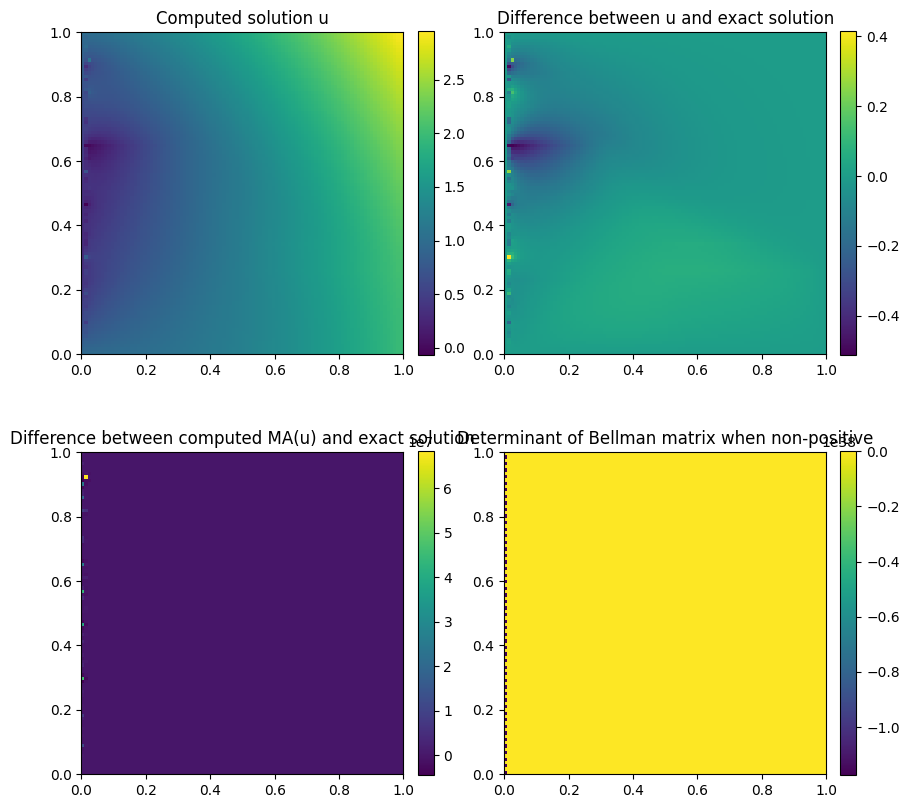

N =  100
Computed solution : Maximal error =  5.13e-01 Average l^2 error =  6.99e-04
Computed MA       : Maximal error =  6.83e+07 Average l^2 error =  1.17e+04  Two outermost layers excluded
Degeneracy count =  3925 (40.9%)


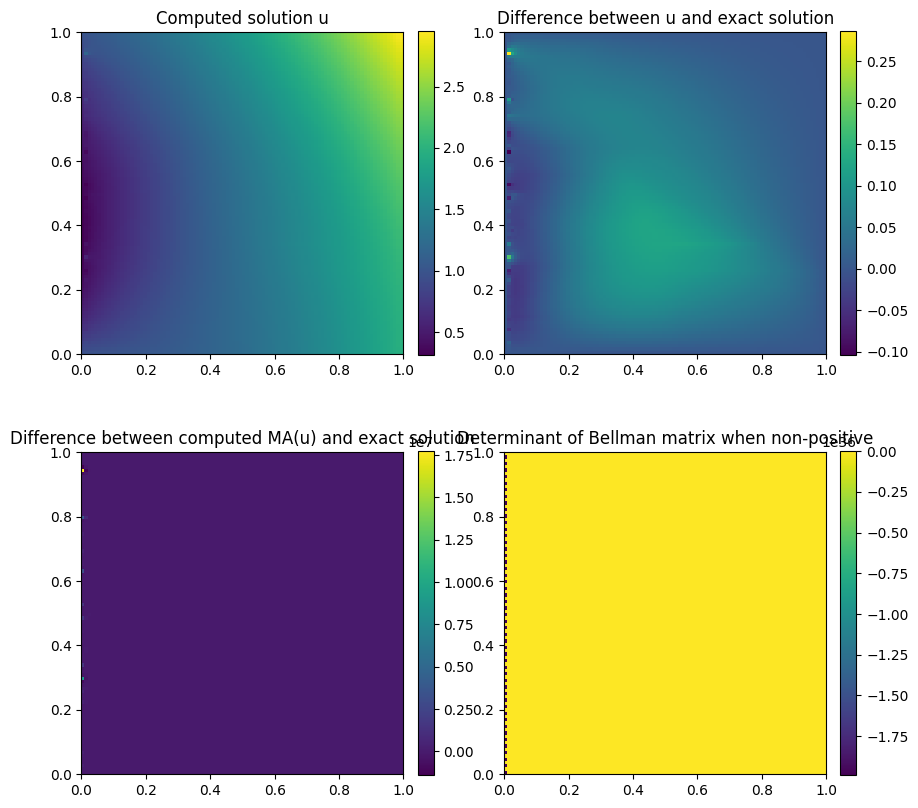

N =  100
Computed solution : Maximal error =  2.86e-01 Average l^2 error =  5.61e-04
Computed MA       : Maximal error =  1.77e+07 Average l^2 error =  2.16e+03  Two outermost layers excluded
Degeneracy count =  3947 (41.1%)


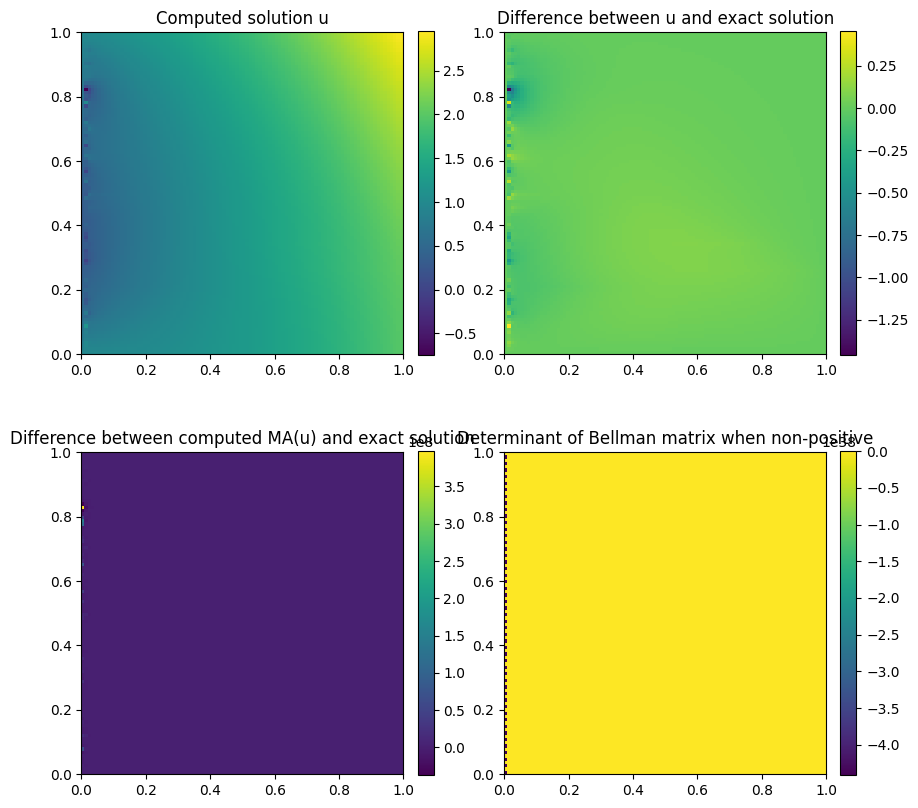

N =  100
Computed solution : Maximal error =  1.46e+00 Average l^2 error =  5.30e-04
Computed MA       : Maximal error =  3.97e+08 Average l^2 error =  4.83e+04  Two outermost layers excluded
Degeneracy count =  3829 (39.9%)


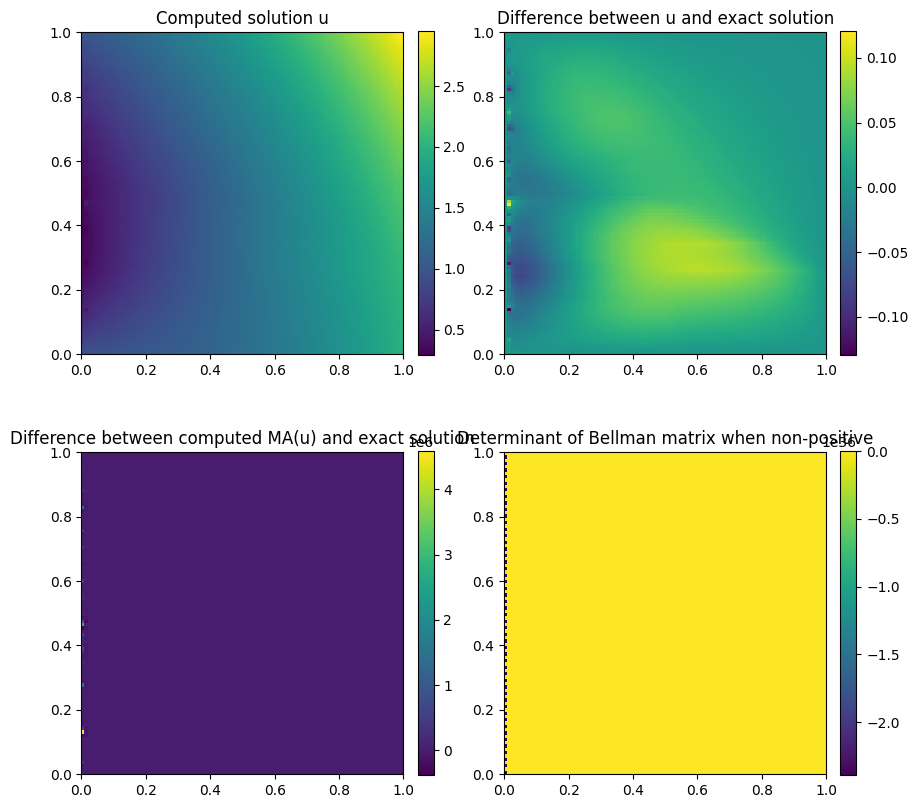

N =  100
Computed solution : Maximal error =  1.30e-01 Average l^2 error =  3.70e-04
Computed MA       : Maximal error =  4.58e+06 Average l^2 error =  6.40e+02  Two outermost layers excluded
Degeneracy count =  3614 (37.6%)


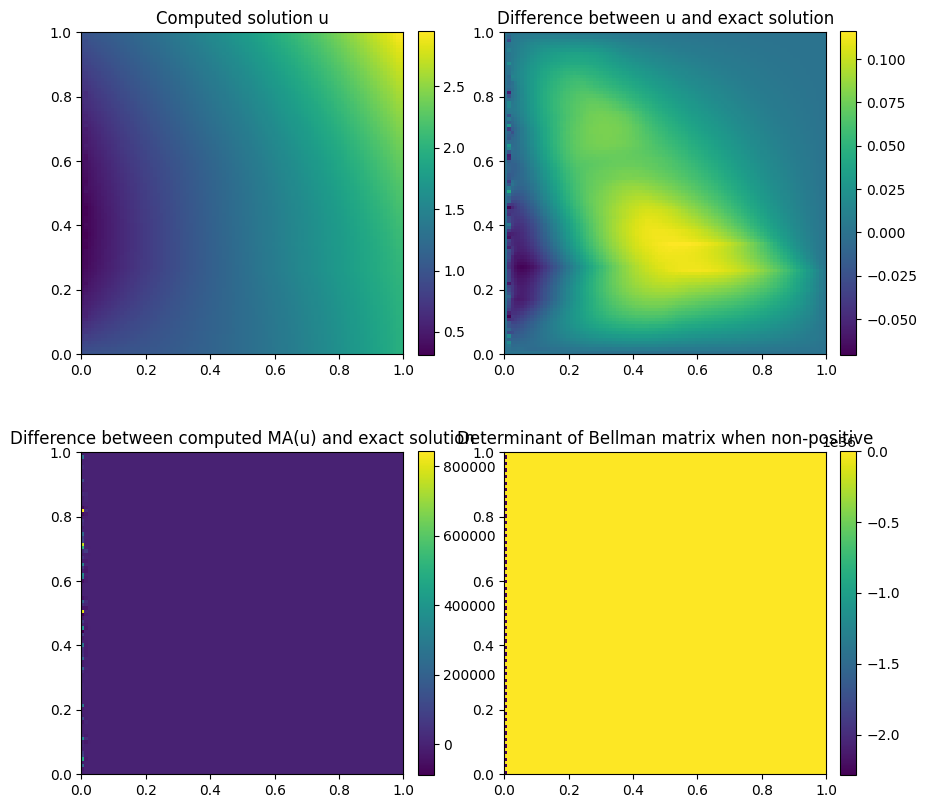

N =  100
Computed solution : Maximal error =  1.16e-01 Average l^2 error =  5.21e-04
Computed MA       : Maximal error =  8.44e+05 Average l^2 error =  1.97e+02  Two outermost layers excluded
Degeneracy count =  3545 (36.9%)


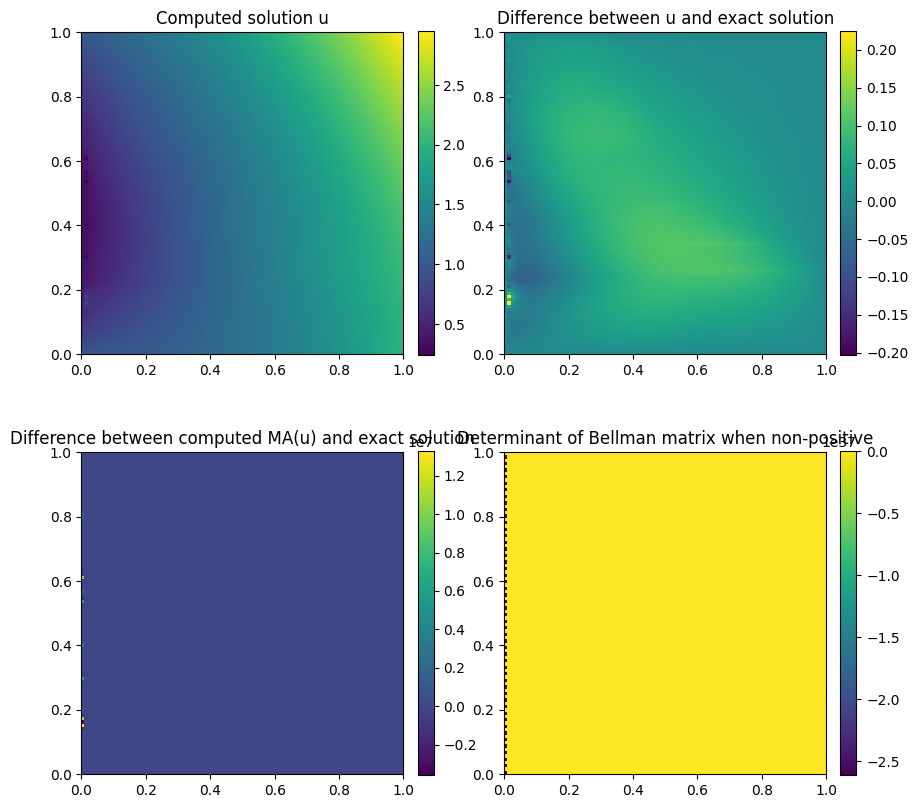

N =  100
Computed solution : Maximal error =  2.25e-01 Average l^2 error =  5.17e-04
Computed MA       : Maximal error =  1.33e+07 Average l^2 error =  2.35e+03  Two outermost layers excluded
Degeneracy count =  3418 (35.6%)


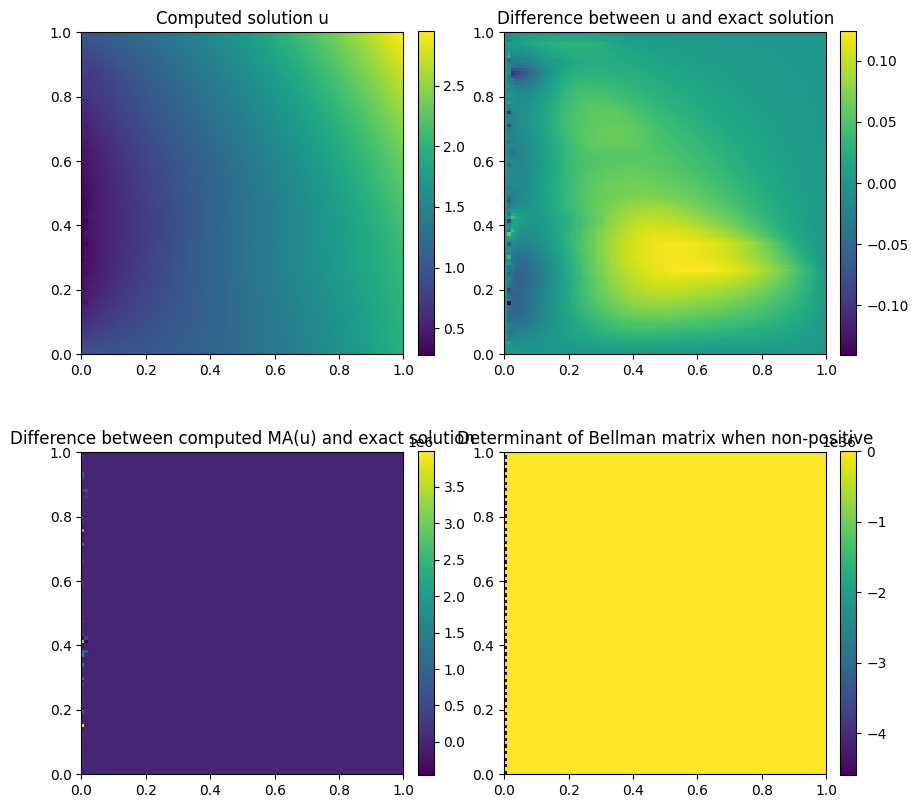

N =  100
Computed solution : Maximal error =  1.41e-01 Average l^2 error =  4.93e-04
Computed MA       : Maximal error =  3.99e+06 Average l^2 error =  7.45e+02  Two outermost layers excluded
Degeneracy count =  3421 (35.6%)


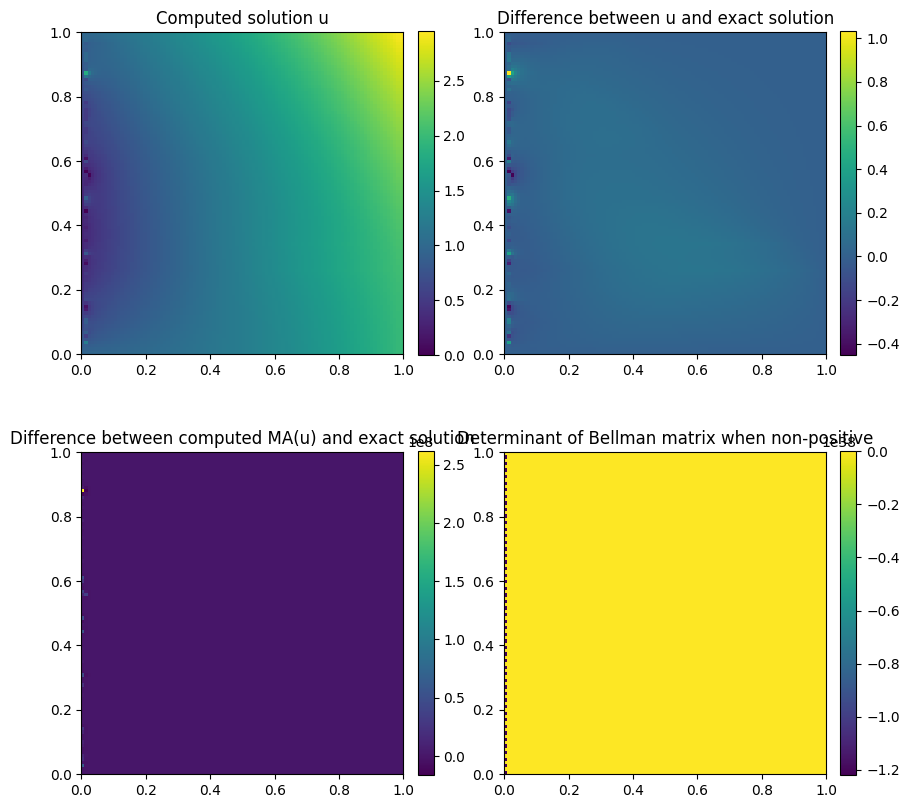

N =  100
Computed solution : Maximal error =  1.03e+00 Average l^2 error =  6.12e-04
Computed MA       : Maximal error =  2.61e+08 Average l^2 error =  3.12e+04  Two outermost layers excluded
Degeneracy count =  3421 (35.6%)


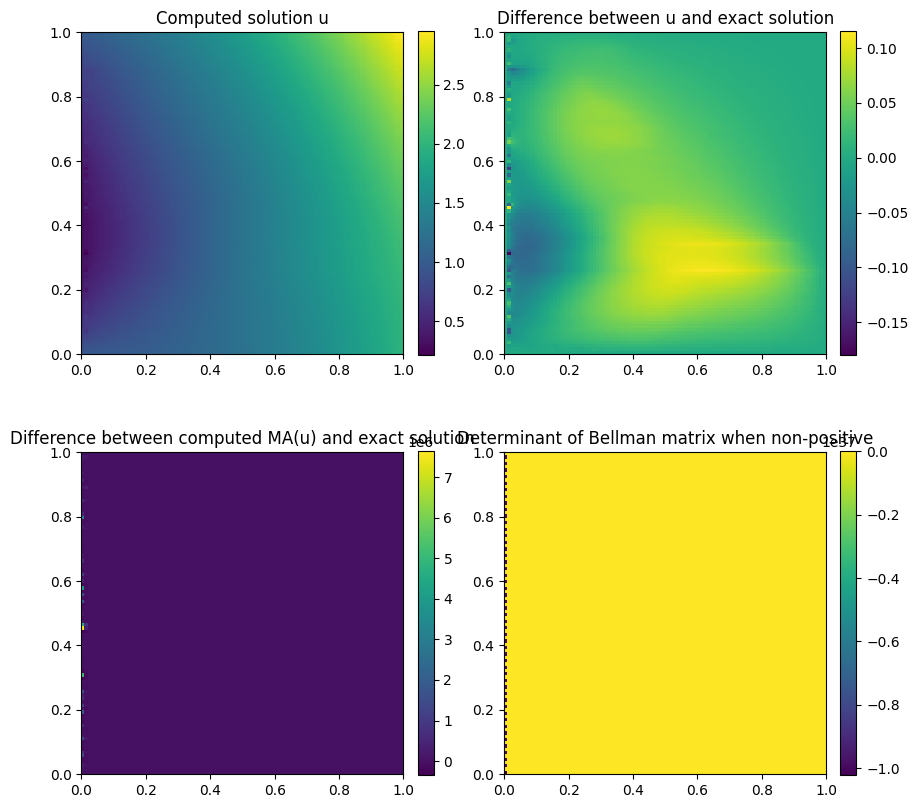

N =  100
Computed solution : Maximal error =  1.80e-01 Average l^2 error =  4.64e-04
Computed MA       : Maximal error =  7.64e+06 Average l^2 error =  1.30e+03  Two outermost layers excluded
Degeneracy count =  3432 (35.7%)


In [34]:

B00 = 1 + np.zeros(shape)
B01 = np.zeros(shape)
B11 = 1 + np.zeros(shape)

for i in range(20):
    L = Coef(B00) * d2_dx2 + Coef(B01)*d2_dxdy + Coef(B01)*d2_dydx + Coef(B11)*d2_dy2

    pde = PDE(L, f, bc)
    u = pde.solve()
        
    u00 = d2_dx2(u)
    u01 = 0.5 * (d2_dxdy(u) + d2_dydx(u))
    u11 = d2_dy2(u)
    
    for i in range(shape[0]):
        for j in range(shape[1]):

            B, singularity[i][j] = Bellman(u00[i][j], u01[i][j], u11[i][j])
            
            if (i == 0 or i == shape[0] or j == 0 or j == shape[1]):
                singularity[i][j] = 0

            B00[i][j] = B[0][0]
            B01[i][j] = B[0][1]
            B11[i][j] = B[1][1]
    for k in range(N):
        r1=0
        r2=0
        c1=0
        c2=0
        #print("last","k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)
        for j in range(N):
            if singularity[k][j]!=0:
                c1=search_points_c1(k,j)
                c2=search_points_c2(k,j)
                r1=search_points_r1(k,j)
                r2=search_points_r2(k,j)
                #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)
                B=interpolation(k,j,r1,r2,c1,c2)
                B00[k][j]=B[0][0]
                B01[k][j]=B[0][1]
                B11[k][j]=B[1][1]
            #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)

    ## Idea for improvement:
    ## Loop over the grid again. At points where singularity[i][j] = 1, replace the identity matrix 
    ## by a suitably computed "linear interpolation" between points where B is computed in a reasonable
    ## way. For example, search in x- and y-directions for points where singularity == 0 and compute 
    ## B as a normalized (to get det=1) convex combination of the corresponding B's.
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    im = ax[0][0].imshow(np.flip(u[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    ax[0][0].set_title('Computed solution u')

    fig.colorbar(im, ax=ax[0][0], fraction=0.046, pad=0.04)

    delta = np.flip(np.transpose(u-exact), 0)
    
    im_delta = ax[0][1].imshow(delta[1:-1,1:-1], extent=[0,1,0,1])
    fig.colorbar(im_delta, ax=ax[0][1], fraction=0.046, pad=0.04)
    ax[0][1].set_title('Difference between u and exact solution')

    diff_MA = np.flip(np.transpose(u00*u11-u01**2 - MA), 0)
    im_diff_ma = ax[1][0].imshow(diff_MA[2:-2,2:-2], extent=[0,1,0,1])
    fig.colorbar(im_diff_ma, ax=ax[1][0], fraction=0.046, pad=0.04)
    ax[1][0].set_title('Difference between computed MA(u) and exact solution')
    
    im_sing = ax[1][1].imshow(np.flip(singularity[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    fig.colorbar(im_sing, ax=ax[1][1], fraction=0.046, pad=0.04)
    ax[1][1].set_title('Determinant of Bellman matrix when non-positive')

    plt.show()

    SingularityCount = np.count_nonzero(singularity[1:-1,1:-1])
    print("N = ", "{0:3d}".format(N))
    print("Computed solution : Maximal error = ", "{0:.2e}".format(np.max(np.abs(delta[1:-1,1:-1]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(delta[1:-1,1:-1]) / (N-2)**2))
    print("Computed MA       : Maximal error = ", "{0:.2e}".format(np.max(np.abs(diff_MA[2:-2,2:-2]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(diff_MA[2:-2,2:-2]) / (N-2)**2), " Two outermost layers excluded")
    print("Degeneracy count = ", SingularityCount, "({0:.1f}%)".format(100*SingularityCount/(N-2)**2))


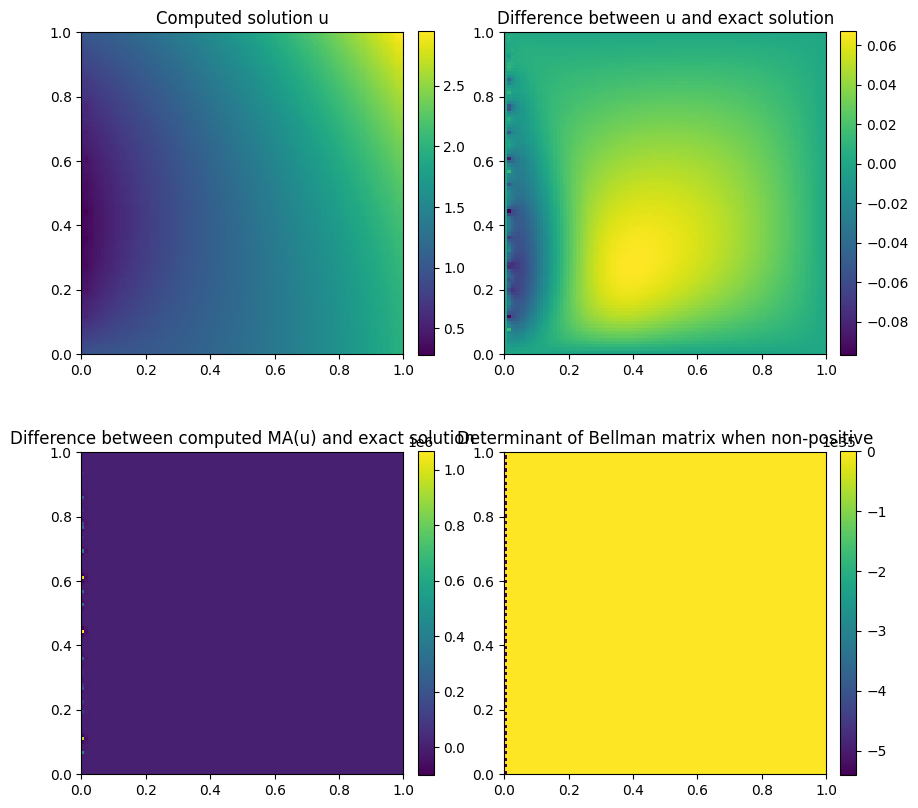

N =  100
Computed solution : Maximal error =  9.70e-02 Average l^2 error =  3.36e-04
Computed MA       : Maximal error =  1.07e+06 Average l^2 error =  2.07e+02  Two outermost layers excluded
Degeneracy count =  3669 (38.2%)


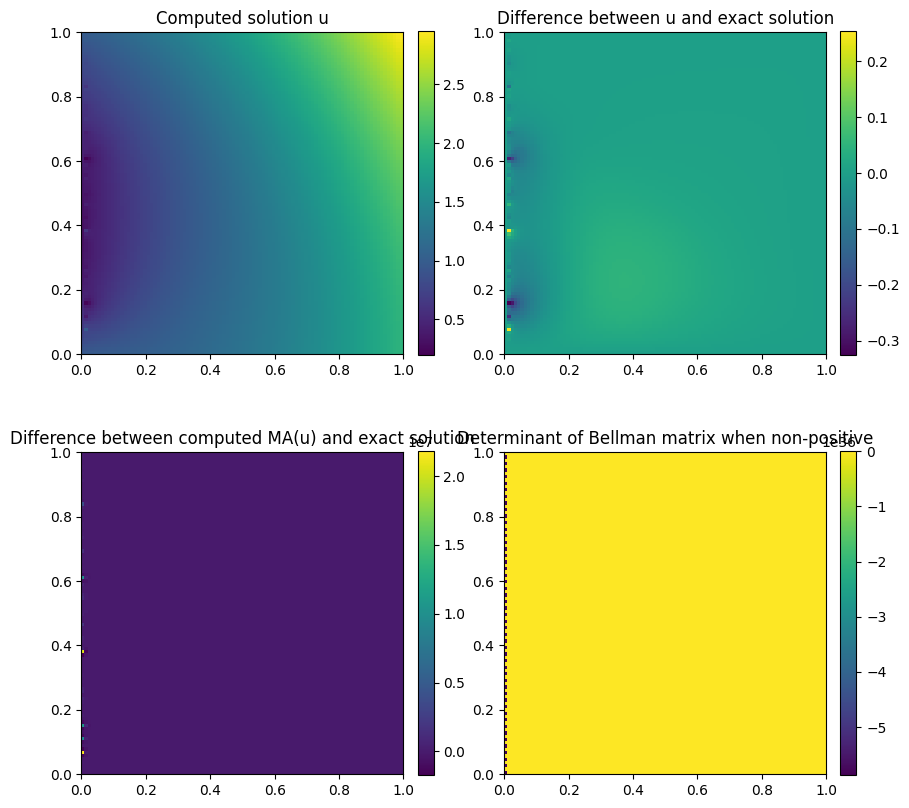

N =  100
Computed solution : Maximal error =  3.26e-01 Average l^2 error =  2.37e-04
Computed MA       : Maximal error =  2.18e+07 Average l^2 error =  3.69e+03  Two outermost layers excluded
Degeneracy count =  3464 (36.1%)


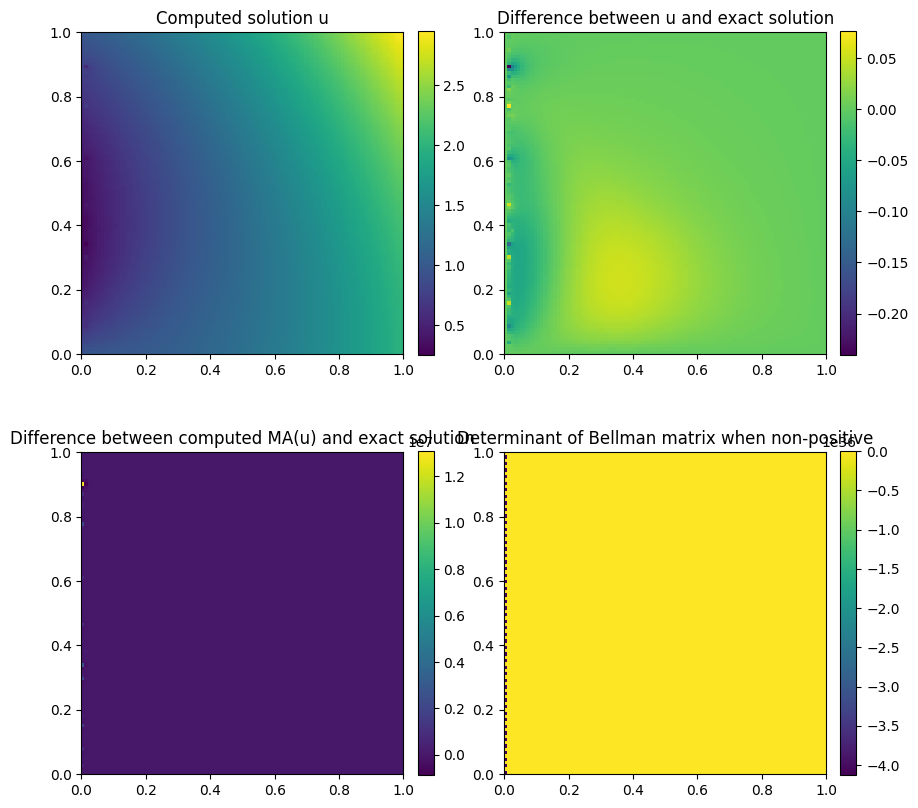

N =  100
Computed solution : Maximal error =  2.41e-01 Average l^2 error =  1.99e-04
Computed MA       : Maximal error =  1.31e+07 Average l^2 error =  1.47e+03  Two outermost layers excluded
Degeneracy count =  3421 (35.6%)


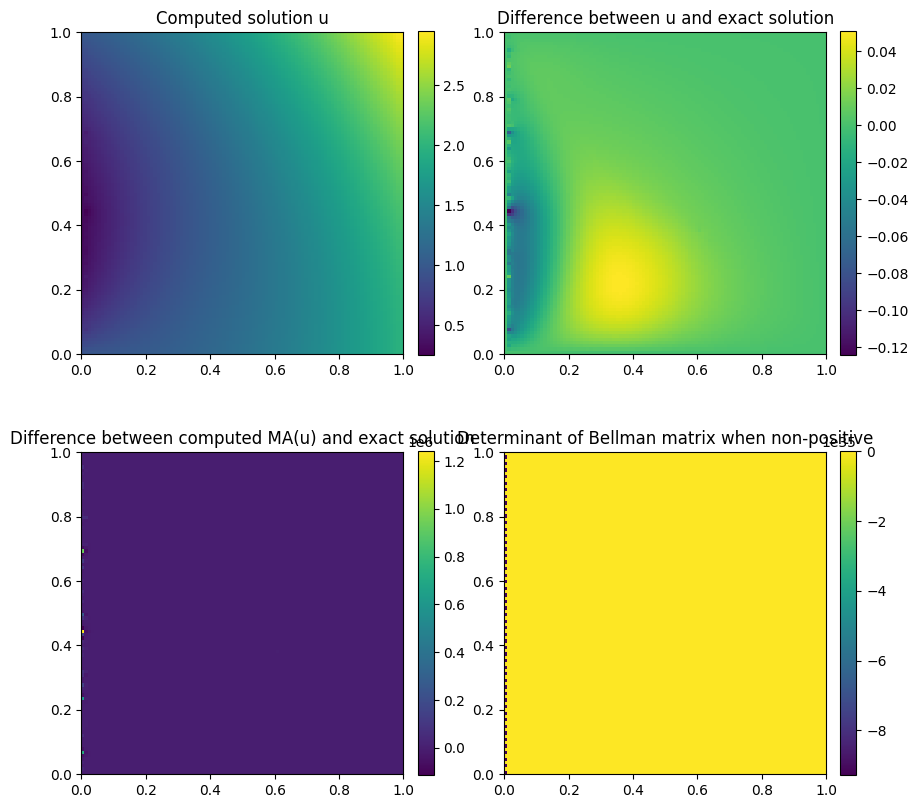

N =  100
Computed solution : Maximal error =  1.24e-01 Average l^2 error =  1.89e-04
Computed MA       : Maximal error =  1.24e+06 Average l^2 error =  1.96e+02  Two outermost layers excluded
Degeneracy count =  3417 (35.6%)


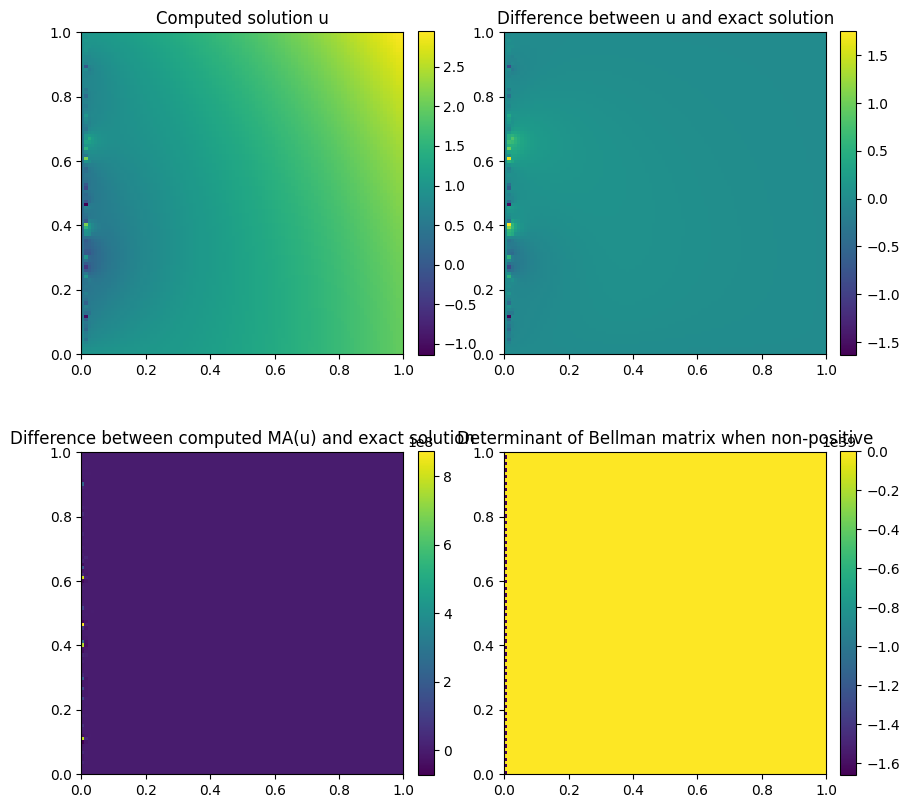

N =  100
Computed solution : Maximal error =  1.75e+00 Average l^2 error =  7.90e-04
Computed MA       : Maximal error =  8.73e+08 Average l^2 error =  1.78e+05  Two outermost layers excluded
Degeneracy count =  3524 (36.7%)


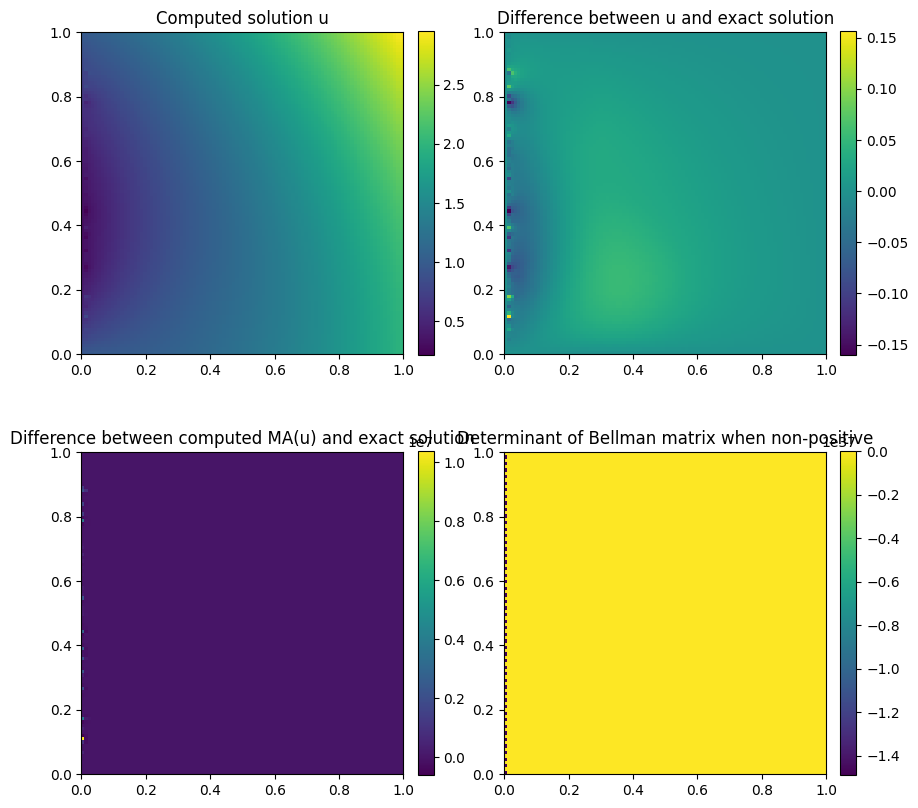

N =  100
Computed solution : Maximal error =  1.60e-01 Average l^2 error =  2.24e-04
Computed MA       : Maximal error =  1.04e+07 Average l^2 error =  1.41e+03  Two outermost layers excluded
Degeneracy count =  3369 (35.1%)


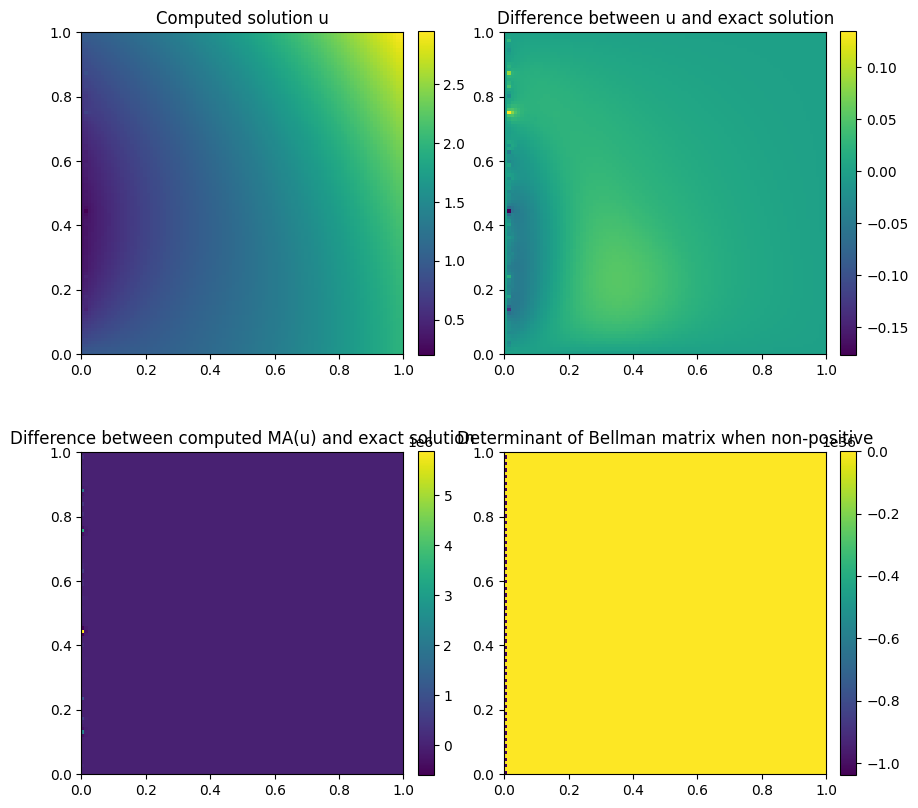

N =  100
Computed solution : Maximal error =  1.77e-01 Average l^2 error =  2.08e-04
Computed MA       : Maximal error =  5.88e+06 Average l^2 error =  7.90e+02  Two outermost layers excluded
Degeneracy count =  3279 (34.1%)


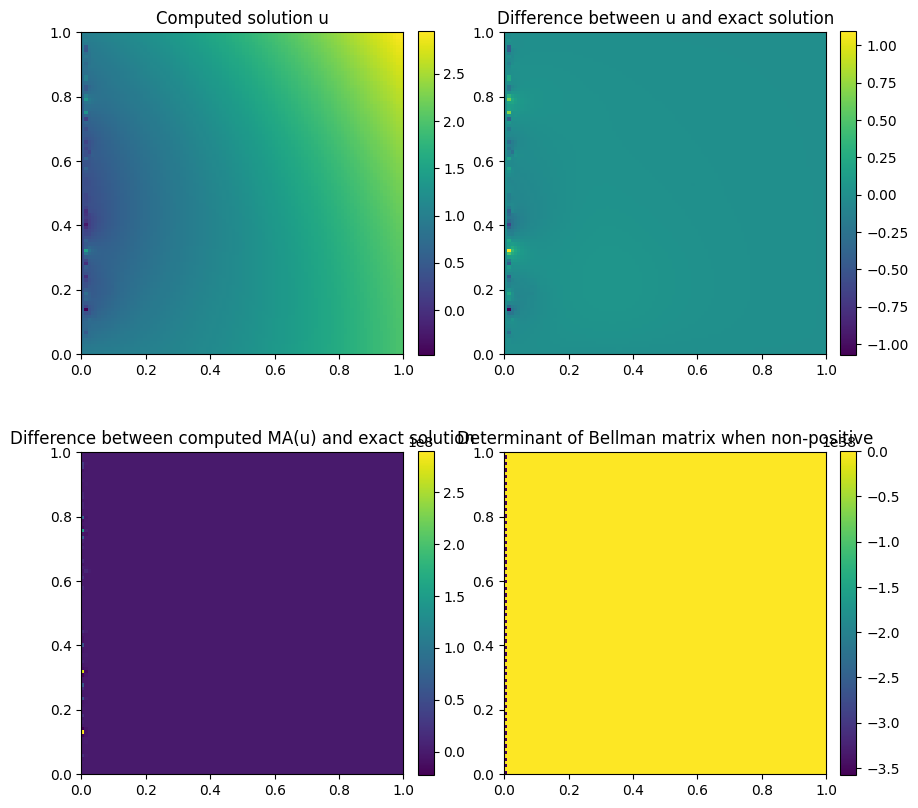

N =  100
Computed solution : Maximal error =  1.09e+00 Average l^2 error =  3.81e-04
Computed MA       : Maximal error =  2.90e+08 Average l^2 error =  4.73e+04  Two outermost layers excluded
Degeneracy count =  3296 (34.3%)


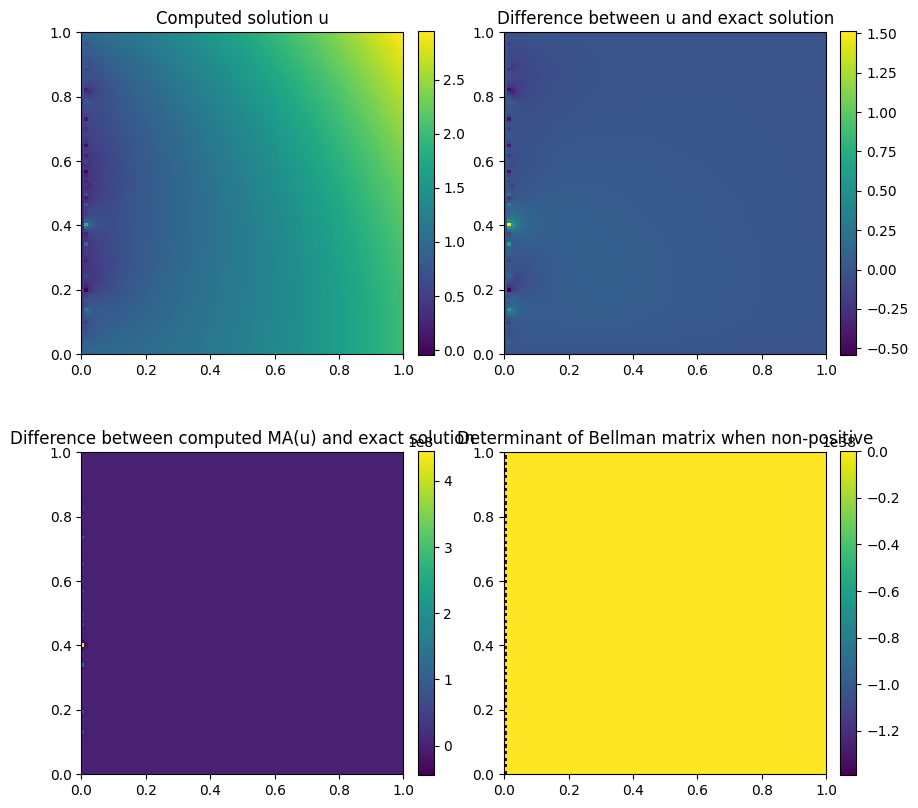

N =  100
Computed solution : Maximal error =  1.51e+00 Average l^2 error =  4.57e-04
Computed MA       : Maximal error =  4.45e+08 Average l^2 error =  5.12e+04  Two outermost layers excluded
Degeneracy count =  3635 (37.8%)


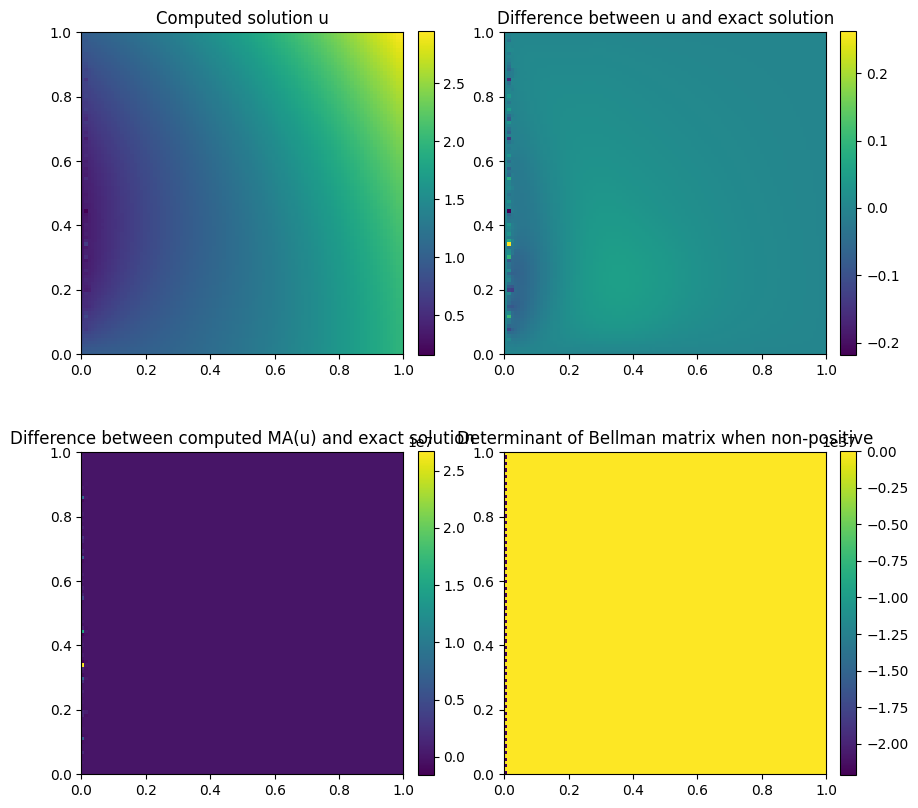

N =  100
Computed solution : Maximal error =  2.62e-01 Average l^2 error =  2.14e-04
Computed MA       : Maximal error =  2.67e+07 Average l^2 error =  3.61e+03  Two outermost layers excluded
Degeneracy count =  3268 (34.0%)


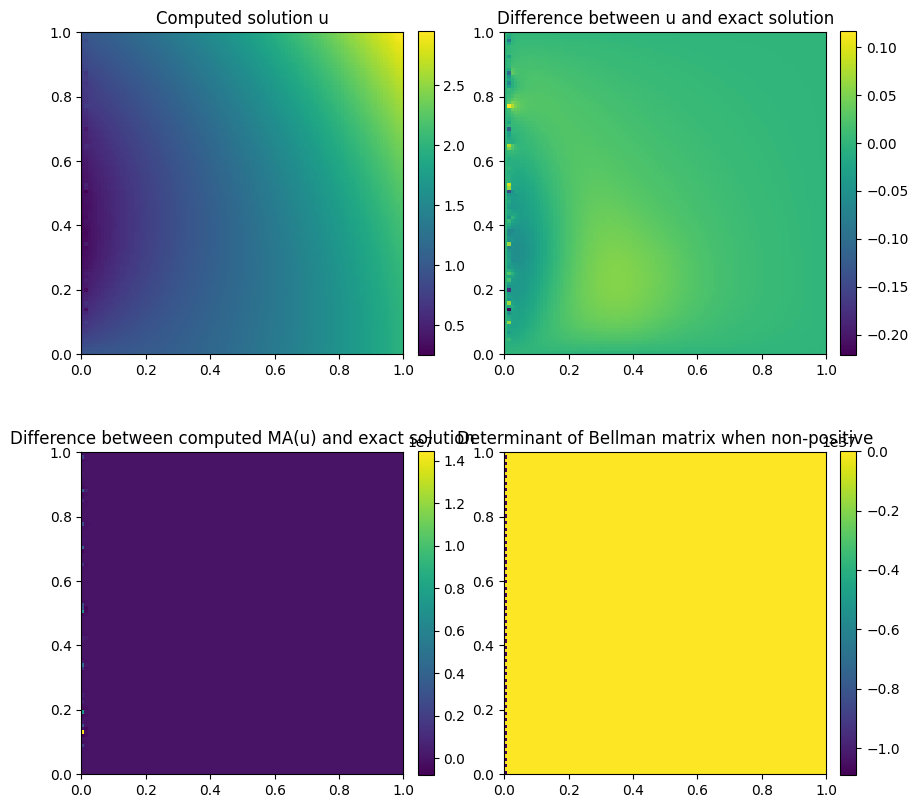

N =  100
Computed solution : Maximal error =  2.21e-01 Average l^2 error =  2.11e-04
Computed MA       : Maximal error =  1.44e+07 Average l^2 error =  2.13e+03  Two outermost layers excluded
Degeneracy count =  3254 (33.9%)


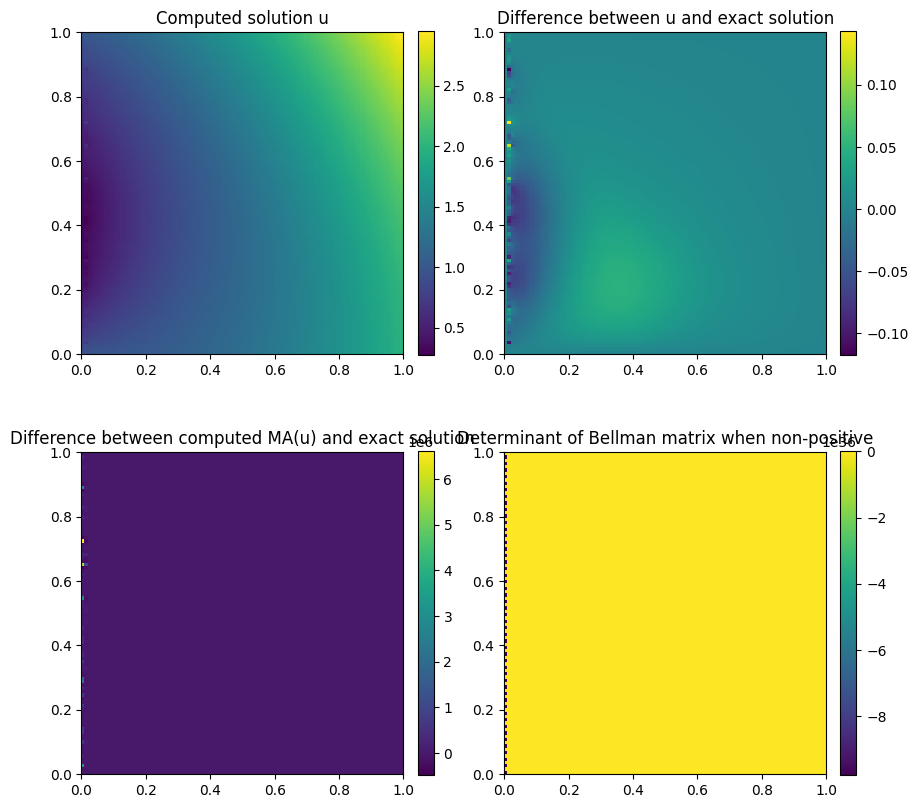

N =  100
Computed solution : Maximal error =  1.43e-01 Average l^2 error =  1.86e-04
Computed MA       : Maximal error =  6.61e+06 Average l^2 error =  1.16e+03  Two outermost layers excluded
Degeneracy count =  3260 (33.9%)


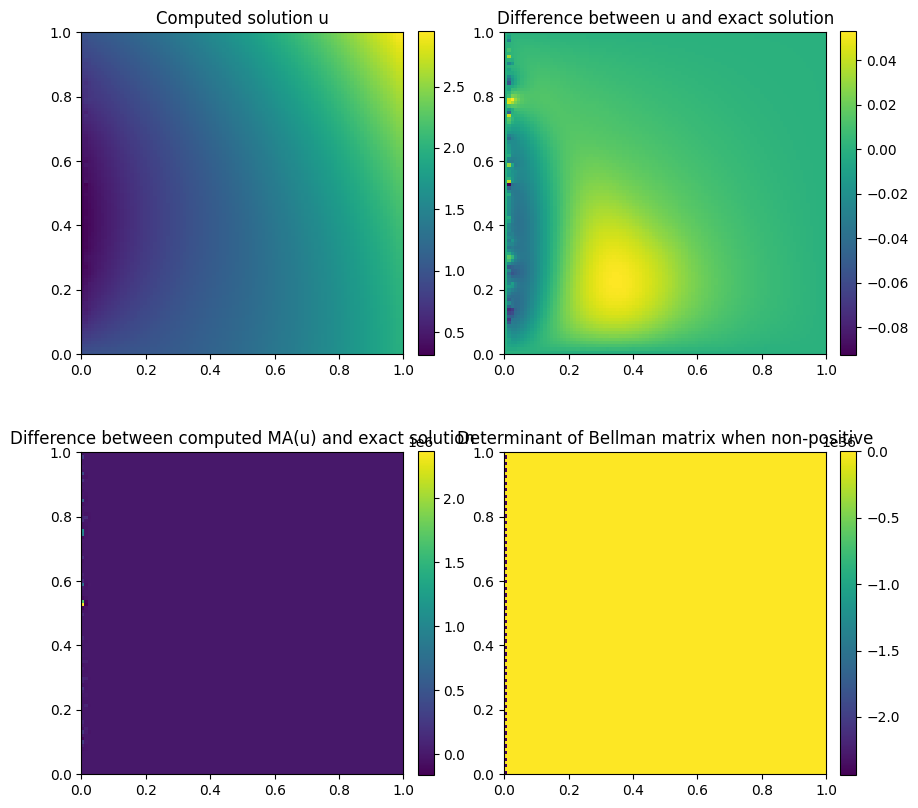

N =  100
Computed solution : Maximal error =  9.26e-02 Average l^2 error =  1.86e-04
Computed MA       : Maximal error =  2.37e+06 Average l^2 error =  3.61e+02  Two outermost layers excluded
Degeneracy count =  3245 (33.8%)


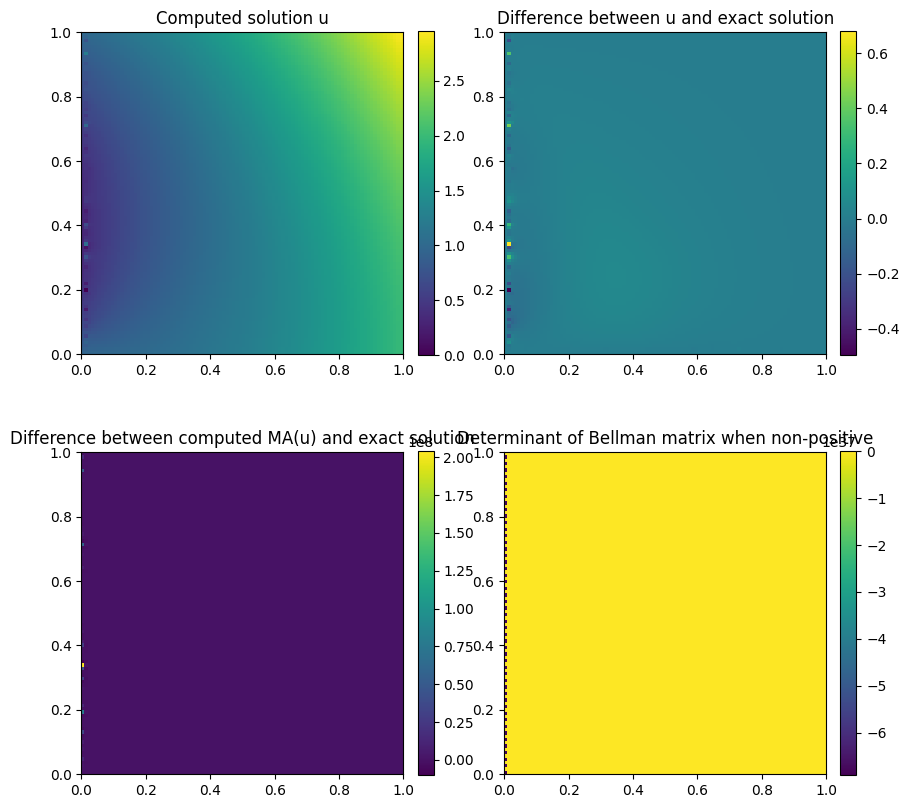

N =  100
Computed solution : Maximal error =  6.79e-01 Average l^2 error =  2.48e-04
Computed MA       : Maximal error =  2.04e+08 Average l^2 error =  2.54e+04  Two outermost layers excluded
Degeneracy count =  3250 (33.8%)


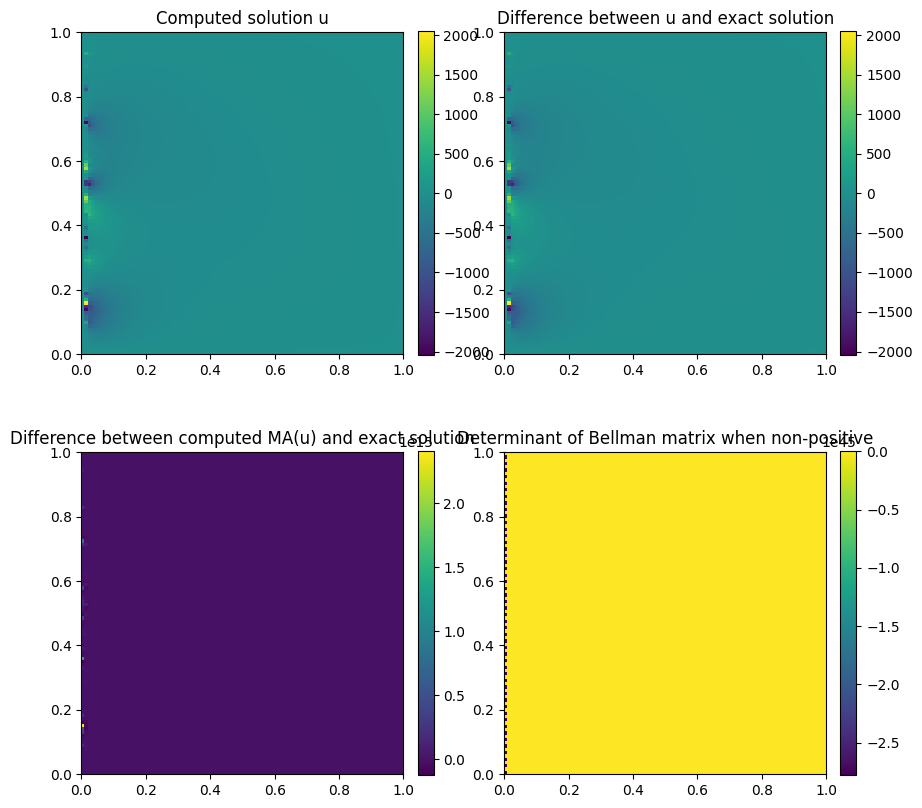

N =  100
Computed solution : Maximal error =  2.05e+03 Average l^2 error =  1.19e+00
Computed MA       : Maximal error =  2.41e+15 Average l^2 error =  3.27e+11  Two outermost layers excluded
Degeneracy count =  9403 (97.9%)


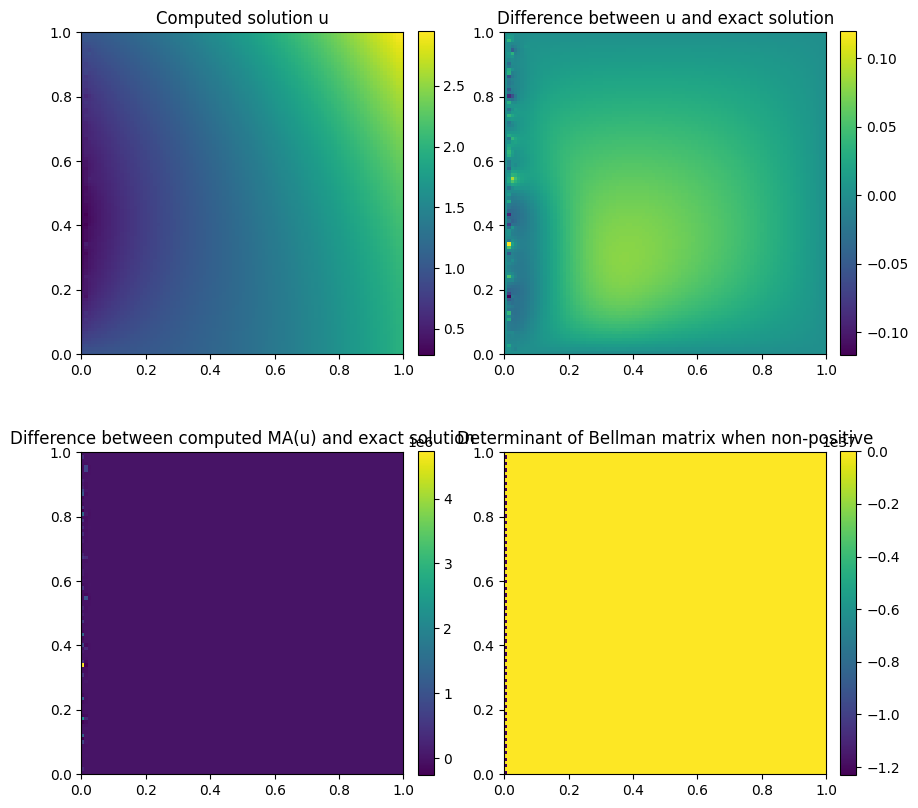

N =  100
Computed solution : Maximal error =  1.20e-01 Average l^2 error =  3.86e-04
Computed MA       : Maximal error =  4.73e+06 Average l^2 error =  6.79e+02  Two outermost layers excluded
Degeneracy count =  3578 (37.3%)


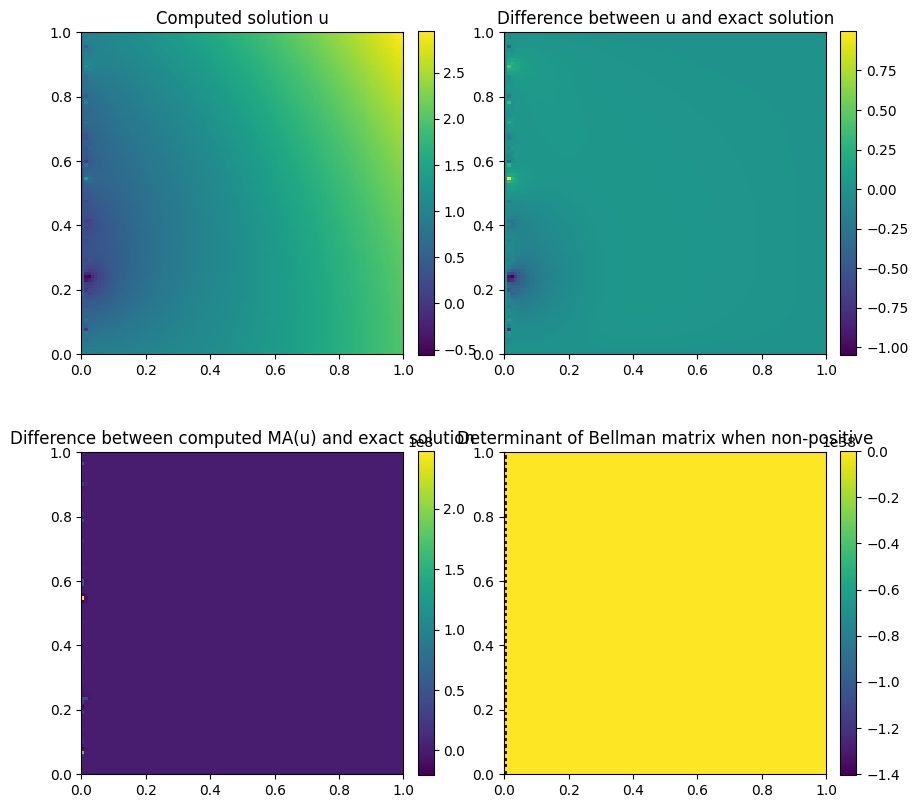

N =  100
Computed solution : Maximal error =  1.05e+00 Average l^2 error =  5.52e-04
Computed MA       : Maximal error =  2.48e+08 Average l^2 error =  3.48e+04  Two outermost layers excluded
Degeneracy count =  3605 (37.5%)


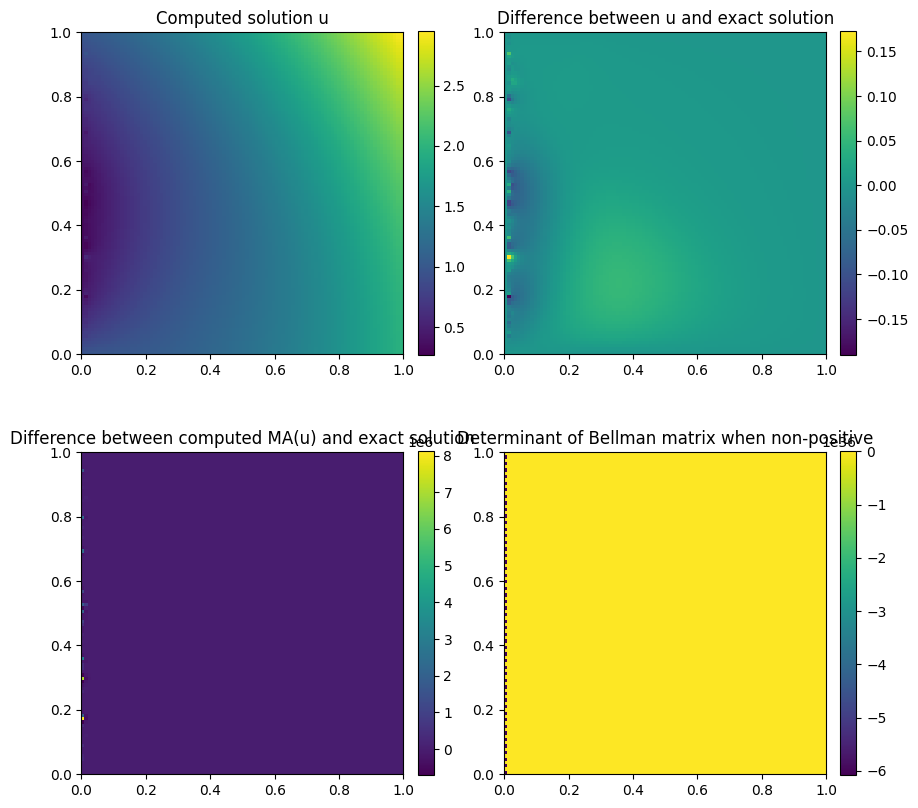

N =  100
Computed solution : Maximal error =  1.91e-01 Average l^2 error =  1.97e-04
Computed MA       : Maximal error =  8.12e+06 Average l^2 error =  1.31e+03  Two outermost layers excluded
Degeneracy count =  3401 (35.4%)


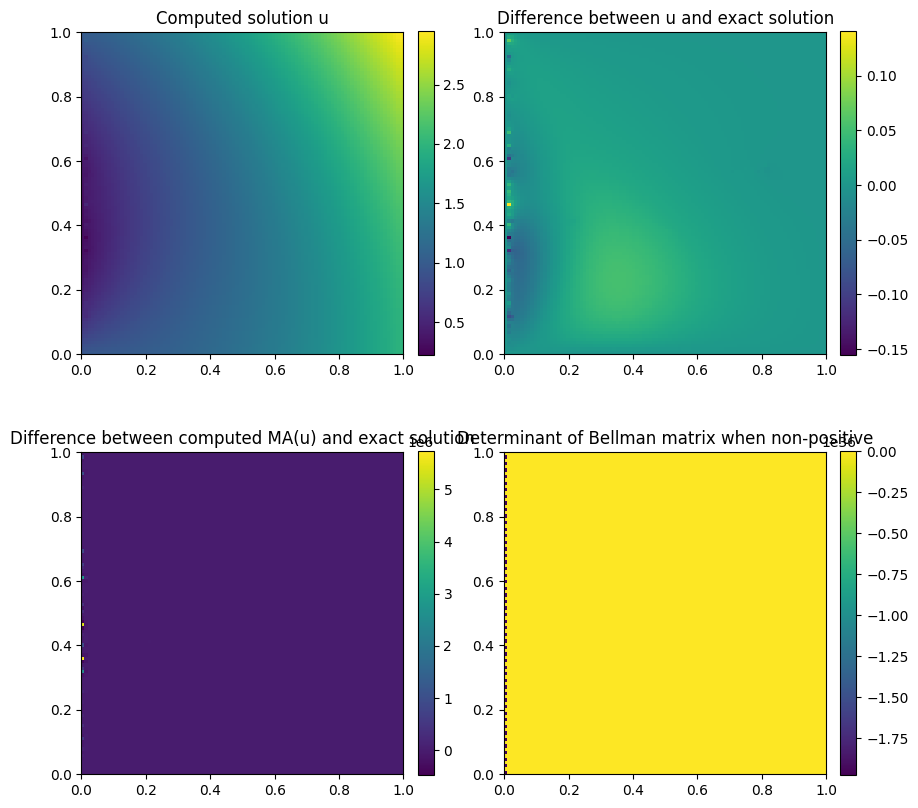

N =  100
Computed solution : Maximal error =  1.56e-01 Average l^2 error =  1.91e-04
Computed MA       : Maximal error =  5.73e+06 Average l^2 error =  9.42e+02  Two outermost layers excluded
Degeneracy count =  3414 (35.5%)


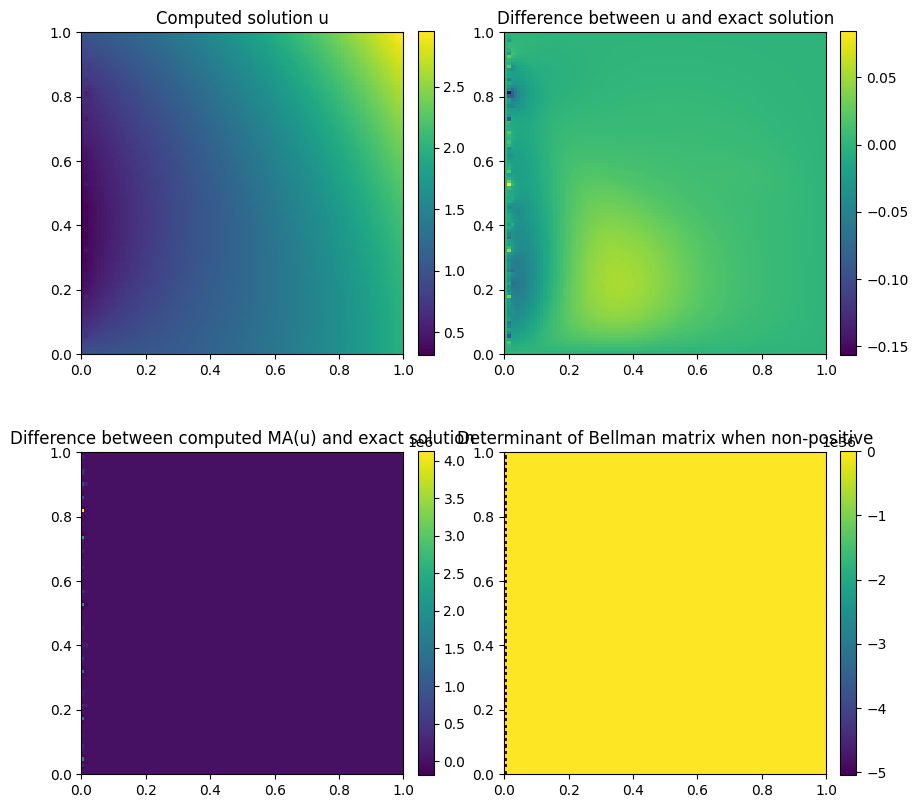

N =  100
Computed solution : Maximal error =  1.57e-01 Average l^2 error =  1.90e-04
Computed MA       : Maximal error =  4.12e+06 Average l^2 error =  6.46e+02  Two outermost layers excluded
Degeneracy count =  3290 (34.3%)


In [35]:

B00 = 1 + np.zeros(shape)
B01 = np.zeros(shape)
B11 = 1 + np.zeros(shape)

for i in range(20):
    L = Coef(B00) * d2_dx2 + Coef(B01)*d2_dxdy + Coef(B01)*d2_dydx + Coef(B11)*d2_dy2

    pde = PDE(L, f, bc)
    u = pde.solve()
        
    u00 = d2_dx2(u)
    u01 = 0.5 * (d2_dxdy(u) + d2_dydx(u))
    u11 = d2_dy2(u)
    
    for i in range(shape[0]):
        for j in range(shape[1]):

            B, singularity[i][j] = Bellman(u00[i][j], u01[i][j], u11[i][j])
            
            if (i == 0 or i == shape[0] or j == 0 or j == shape[1]):
                singularity[i][j] = 0

            B00[i][j] = B[0][0]
            B01[i][j] = B[0][1]
            B11[i][j] = B[1][1]

    ## Idea for improvement:
    ## Loop over the grid again. At points where singularity[i][j] = 1, replace the identity matrix 
    ## by a suitably computed "linear interpolation" between points where B is computed in a reasonable
    ## way. For example, search in x- and y-directions for points where singularity == 0 and compute 
    ## B as a normalized (to get det=1) convex combination of the corresponding B's.
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    im = ax[0][0].imshow(np.flip(u[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    ax[0][0].set_title('Computed solution u')

    fig.colorbar(im, ax=ax[0][0], fraction=0.046, pad=0.04)

    delta = np.flip(np.transpose(u-exact), 0)
    
    im_delta = ax[0][1].imshow(delta[1:-1,1:-1], extent=[0,1,0,1])
    fig.colorbar(im_delta, ax=ax[0][1], fraction=0.046, pad=0.04)
    ax[0][1].set_title('Difference between u and exact solution')

    diff_MA = np.flip(np.transpose(u00*u11-u01**2 - MA), 0)
    im_diff_ma = ax[1][0].imshow(diff_MA[2:-2,2:-2], extent=[0,1,0,1])
    fig.colorbar(im_diff_ma, ax=ax[1][0], fraction=0.046, pad=0.04)
    ax[1][0].set_title('Difference between computed MA(u) and exact solution')
    
    im_sing = ax[1][1].imshow(np.flip(singularity[1:-1,1:-1].transpose(), 0), extent=[0,1,0,1])
    fig.colorbar(im_sing, ax=ax[1][1], fraction=0.046, pad=0.04)
    ax[1][1].set_title('Determinant of Bellman matrix when non-positive')

    plt.show()

    SingularityCount = np.count_nonzero(singularity[1:-1,1:-1])
    print("N = ", "{0:3d}".format(N))
    print("Computed solution : Maximal error = ", "{0:.2e}".format(np.max(np.abs(delta[1:-1,1:-1]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(delta[1:-1,1:-1]) / (N-2)**2))
    print("Computed MA       : Maximal error = ", "{0:.2e}".format(np.max(np.abs(diff_MA[2:-2,2:-2]))), "Average l^2 error = ", "{0:.2e}".format(LA.norm(diff_MA[2:-2,2:-2]) / (N-2)**2), " Two outermost layers excluded")
    print("Degeneracy count = ", SingularityCount, "({0:.1f}%)".format(100*SingularityCount/(N-2)**2))


In [36]:
for k in range(1,3):
    r1=0
    r2=0
    c1=0
    c2=0
    #print("last","k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)
    for j in range(N):
        if singularity[k][j]==0:
            c1=j
        else:
            c1=search_points_c1(k,j)
            c2=search_points_c2(k,j,c1)
            r1=search_points_r1(k,j)
            r2=search_points_r2(k,j,r1)
            B=interpolation(k,j,r1,r2,c1,c2)
            B00[k][j]=B[0][0]
            B01[k][j]=B[0][1]
            B11[k][j]=B[1][1]
        #print("k",k,"j",j,"s",singularity[k][j],"c1",c1,"c2",c2,"r1",r1,"r2",r2)

        